# Bed Posture and Subject Classification

TO DO:

- In data load section, include example picture, show the effect of normalization and median filtering, before pre-processing and after pre-processing
- Review accuracy of model on specific positions, not just 3 main positions
- Come up with other models, smaller, without dropout
- try unsupervised approach
- type up results in report

In [2]:
# Set which GPU to use
import os
import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="2"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-07-09 14:57:57.796111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 14:57:58.713588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-09 14:58:00.390488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 14:58:00.456181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [3]:
# Import Libraries

import numpy as np
import pandas as pd
import os
import sys
import time
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from keras.utils.vis_utils import plot_model    

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage

# Other
import math
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter

%matplotlib inline
np.random.seed(123)

## Data Load and preprocessing

We used data from the first experiment in the public PmatData dataset.

Information about the dataset:
- Samples are collected using Vista Medical FSA Soft- Flex 2048
- The main data folder contains 13 directories corresponding to 13 subjects. Each folder contains 17 txt files, which correspond to the 17 possible sleeping postures (8 standard and 9 uncommon postures)
- Each file contains multiple recordings of the subject posture in the form of pressure matrices, sampled at 1Hz. Each row is length 2,048 representing the 64x32 pressure mat size. Pressure ratings range from 0 to 1000
- 2-mins (around 120 frames) of data was recorded per subject

Source of dataset: https://physionet.org/content/pmd/1.0.0/

In [4]:
path = os.getcwd()

In [5]:
# Table of Subject Information
subj_inf = pd.read_csv(path + '/data/experiment-i/subject-info-i.csv', encoding = 'utf_16', index_col='Subject-Number')
display(subj_inf)

,Age,Height/cm,Weight/kg
Subject-Number,,,
1,19,175,87
2,23,183,85
3,23,183,100
4,24,177,70
5,24,172,66
6,26,169,83
7,27,179,96
8,27,186,63
9,30,174,74


In [6]:
# List of Subjects in Experiment I
subj_list = [file for file in os.listdir(path +'/data/experiment-i/') if os.path.isdir(os.path.join(path +'/data/experiment-i/', file))]
print(f"The subjects in Experiment I are: {subj_list}")

The subjects in Experiment I are: ['S9', 'S10', 'S12', 'S7', 'S6', 'S4', 'S1', 'S8', 'S11', 'S3', 'S13', 'S2', 'S5']


In [7]:
# Number of Positions for Each Subject
positions_cnt = [file for file in os.listdir(path +'/data/experiment-i/S5/') if os.path.isfile(os.path.join(path +'/data/experiment-i/S5/', file))]
print(f"The number of positions for each subject are: {len(positions_cnt)}")

The number of positions for each subject are: 17


In [8]:
# macro position vector
positions_i = ["placeholder", "supine", "right",
                     "left", "right", "right",
                     "left", "left", "supine",
                     "supine", "supine", "supine",
                     "supine", "right", "left",
                     "supine", "supine", "supine"]

In [9]:
# Use position names to define 3 common positions

def token_position(x):
    return {
        'supine': 0,
        'left': 1,
        'right': 2,
        'left_fetus': 1,
        'right_fetus': 2
    }[x]

In [10]:
# Tokenize the labels
def token_patient(x):
    return {'S1': 0, 'S2': 1, 'S3': 2, 'S4': 3, 'S5': 4,  'S6': 5, 'S7': 6,
                    'S8': 7, 'S9': 8, 'S10': 9, 'S11': 10, 'S12': 11, 'S13':12}[x]

In [11]:
# Specific position vector

positions_ii = ['placeholder', 'supine','right','left','right_30_roll','right_60_roll','left_30_roll','left_60_roll','supine_star','supine_hand_crossed','supine_knees_up','supine_right_knee_up','supine_left_knee_up','right_fetus','left_fetus','supine_30_inclination','supine_45_inclination','supine_60_inclination']

In [12]:
# Inspect one file
test_read = np.loadtxt(path + '/data/experiment-i/S6/1.txt')
test_read.shape # (101, 2048) = (number of samples, number of sensors (32x64))

(107, 2048)

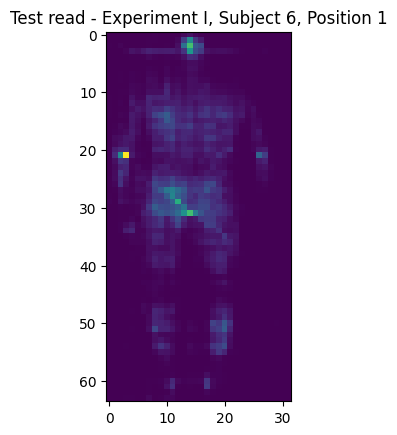

In [13]:
# Example of one sample
plt.title("Test read - Experiment I, Subject 6, Position 1")
plt.imshow(test_read[21,:].reshape(64, 32)) # 22nd sample
plt.show()

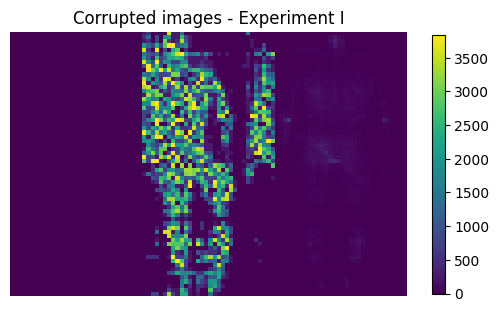

In [14]:
# Show that first three samples are corrupted


# Plot the first three samples
image_0 = test_read[0, :].reshape(64, 32)
image_1 = test_read[1, :].reshape(64, 32)
image_2 = test_read[2, :].reshape(64, 32)

image_concat = np.concatenate((image_0, image_1, image_2), axis=1)

# Show the plot
plt.figure()
plt.imshow(image_concat, cmap='viridis', interpolation='nearest')
plt.title('Corrupted images - Experiment I')
plt.colorbar(shrink=0.7)
plt.axis('off')
plt.show()

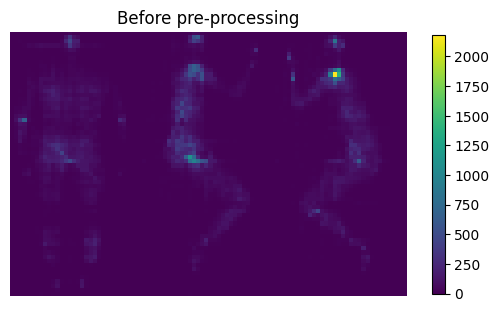

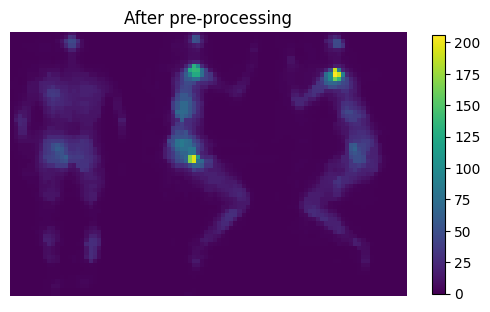

In [15]:
# Demonstrating the effect of pre and post preprocessing for 3 different postures

def preprocess(img):
    median_data = ndimage.median_filter(img, size=(3, 3))
    norm_median_data = np.round(median_data * 255 / 1000).astype(np.uint8)
    return norm_median_data

supine= np.loadtxt(path + '/data/experiment-i/S6/1.txt')
left = np.loadtxt(path + '/data/experiment-i/S6/2.txt')
right = np.loadtxt(path + '/data/experiment-i/S6/3.txt')

image_0 = supine[20, :].reshape(64, 32)
image_1 = left[20, :].reshape(64, 32)
image_2 = right[20, :].reshape(64, 32)

image_concat = np.concatenate((image_0, image_1, image_2), axis=1)

# Show the plot
plt.figure()
plt.imshow(image_concat, cmap='viridis', interpolation='nearest')
plt.title('Before pre-processing')
plt.colorbar(shrink=0.7)
plt.axis('off')
plt.show()

image_0_pp = preprocess(image_0)
image_1_pp = preprocess(image_1)
image_2_pp = preprocess(image_2)

image_concat_pp = np.concatenate((image_0_pp, image_1_pp, image_2_pp), axis=1)

# Show the plot
plt.figure()
plt.imshow(image_concat_pp, cmap='viridis', interpolation='nearest')
plt.title('After pre-processing')
plt.colorbar(shrink=0.7)
plt.axis('off')
plt.show()

In [16]:
# Load all the data into a dictionary, where the keys are the subjects and 
# values: images (index 0), position's number (index 1), and specific position's name (index 2)

# Initialize dictionary to store the data
exp_i_data = {}

# Directory structure: /data/experiment-i/subject/position.txt
for _, dirs, _ in os.walk(path + '/data/experiment-i/'):  
    # Loop through each subject
    for dir in dirs:
        subject = dir
        data = None
        labels = None
        # Loop through each position file in the subject's directory
        for _, _, files in os.walk(path + '/data/experiment-i/' + dir):
            for file in files:
                # Posture path
                file_path = path + '/data/experiment-i/' + dir + '/' + file
                with open(file_path, 'r') as f:
                    # We remove first and last 3 corrupted frames - suggestion from the dataset's authors
                    for line in f.read().splitlines()[3:-3]:
                        raw_data = np.fromstring(line, dtype=float, sep='\t').reshape(1, 64, 32)
                        # apply median filter of 3x3
                        raw_data = ndimage.median_filter(raw_data, size=(1,3,3))

                        # Normalize the data: change range from [0-1000] to [0-255]
                        file_data = np.round(raw_data*255/1000).astype(np.uint8)

                        # Label the data using position number from file name
                        file_label = token_position(positions_i[int(file[:-4])])                        
                        file_label = np.array([file_label])

                        # Specific position label
                        position_label = positions_ii[int(file[:-4])]
                        position_label = np.array([position_label])

                        # Tokenize the position index
                        position_index = int(file[:-4])-1
                        position_index = np.array([position_index])


                        if data is None:
                            data = file_data
                        else:
                            # Concatenate the new data along the first axis
                            data = np.concatenate((data, file_data), axis=0)
                        if labels is None:
                            labels = file_label
                            positions = position_label
                            position_indices = position_index
                        else:
                            labels = np.concatenate((labels, file_label), axis=0)
                            positions = np.concatenate((positions, position_label), axis=0)
                            position_indices = np.concatenate((position_indices, position_index), axis=0)
                        
        exp_i_data[subject] = {'data': data, 'labels': labels, 'position_indices': position_indices, 'positions': positions}

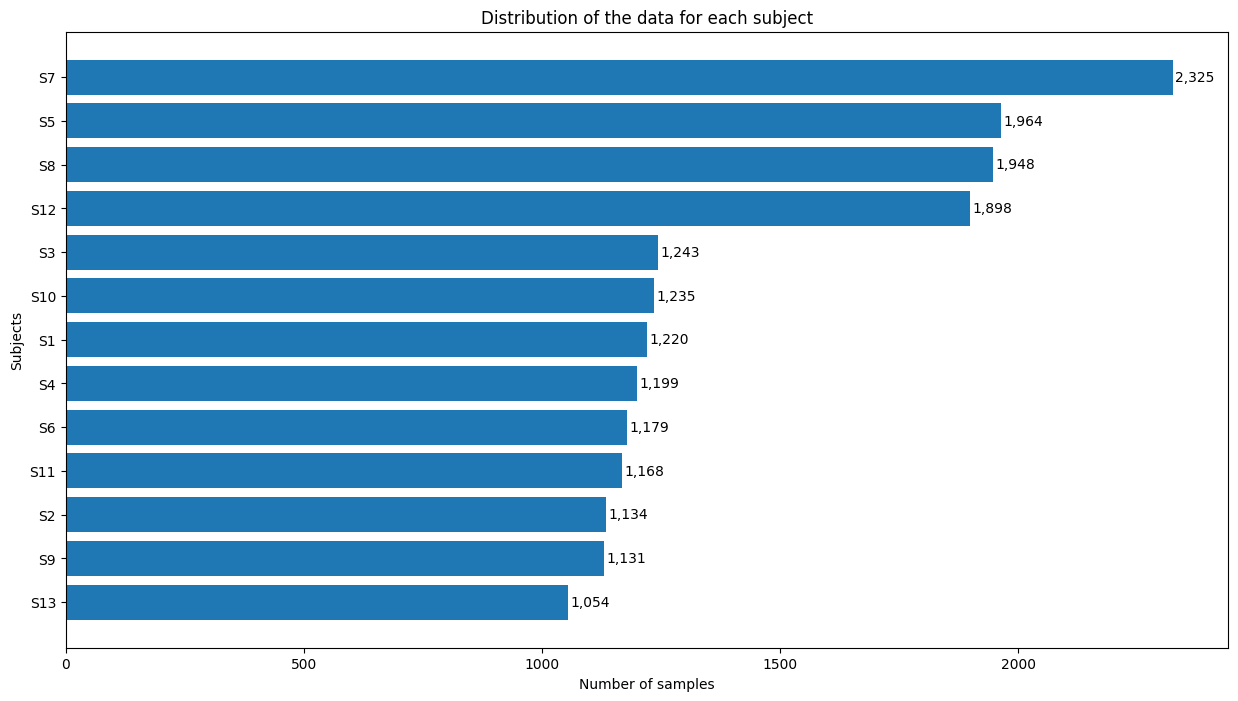

In [17]:
# Distribution of the data for each subjects

data_counts = {}

for subject, data in exp_i_data.items():
    data_counts[subject] = data['data'].shape[0]

sorted_subjects = sorted(data_counts.items(), key=lambda item: item[1])

# Plot the distribution of the data
plt.figure(figsize=(15, 8))
bars = plt.barh([subj for subj, count in sorted_subjects], [count for subj, count in sorted_subjects])

# Add the value at the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,}', va='center', color='black')
plt.xlabel('Number of samples')
plt.ylabel('Subjects')
plt.title('Distribution of the data for each subject')
plt.show()


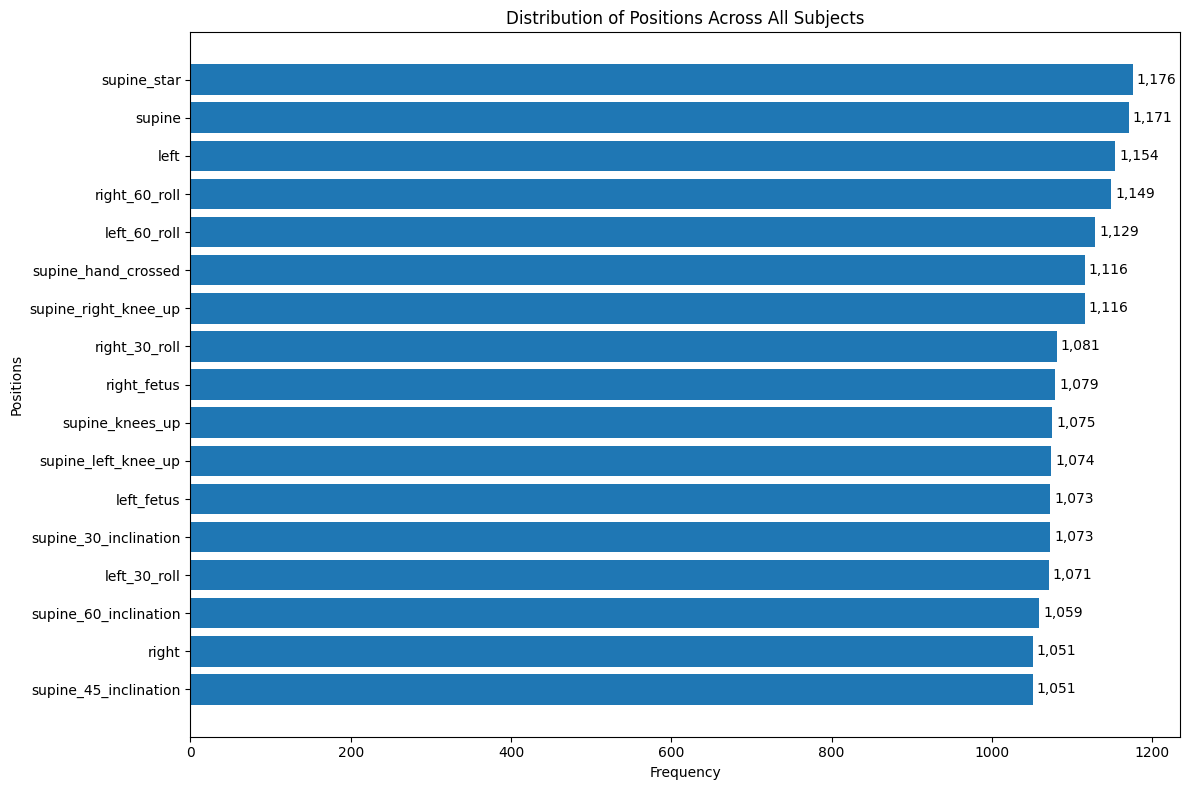

In [18]:
# Show the distribution of the positions across the subjects

position_counts = Counter()

for subject_data in exp_i_data.values():
    position_counts.update(subject_data['positions'])

# Sort positions by count in descending order
sorted_positions_counts = sorted(position_counts.items(), key=lambda item: item[1])
positions, counts = zip(*sorted_positions_counts)

# Plot the distribution of positions
plt.figure(figsize=(12, 8))
bars = plt.barh(positions, counts)

# Add values at the end of each bar
for bar in bars:
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():,}', va='center', color='black')

plt.xlabel('Frequency')
plt.ylabel('Positions')
plt.title('Distribution of Positions Across All Subjects')
plt.tight_layout()
plt.show()



#### Train-Test Split

In [19]:
def create_dataset(ylabel):
    X = []
    y = []
    label_s = []

    for subject in subj_list:
        data = exp_i_data[subject]['data']
        position_label = exp_i_data[subject][ylabel]
        subject_token = np.full(len(data), token_patient(subject))

        X.append(data)
        y.append(position_label)
        label_s.append(subject_token)

    # Concatenate all data, labels, and tokens
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    label_s = np.concatenate(label_s, axis=0)

    return X, y, label_s

In [20]:
# Task 1: Predict the macro position (supine, left, right), ylabel = 'labels'
# Task 2: Predict the specific position (17 positions), ylabel = 'position_indices'
#X, y, label_s = create_dataset('position_indices')
X, y, label_s = create_dataset('labels')


In [21]:
print(X.shape, y.shape, label_s.shape)

(18698, 64, 32) (18698,) (18698,)


In [22]:
# Train-Test Split

# 70% training set, 20% validation set and 10% test set

# Experiment I
indices = np.arange(len(X))
X_train_val, X_test, y_train_val, y_test, indices_train_val, indices_test, = train_test_split(X, y, indices, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(X_train_val, y_train_val, indices_train_val, test_size=0.2222, random_state=123)

# Split label_s accordingly using indices
label_s_train = label_s[indices_train]
label_s_val = label_s[indices_val]
label_s_test = label_s[indices_test]

# Print number of samples in each set
print(f"Number of samples in training set: {len(X_train)} ({len(X_train)/len(X):.2%})")
print(f"Number of samples in validation set: {len(X_val)} ({len(X_val)/len(X):.2%})")
print(f"Number of samples in test set: {len(X_test)} ({len(X_test)/len(X):.2%})")

Number of samples in training set: 13088 (70.00%)
Number of samples in validation set: 3740 (20.00%)
Number of samples in test set: 1870 (10.00%)


In [23]:
# One-hot encode the labels

num_postures = 3

label_s_train = tf.keras.utils.to_categorical(label_s_train, num_classes=13)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_postures)
label_s_val = tf.keras.utils.to_categorical(label_s_val, num_classes=13)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_postures)
label_s_test = tf.keras.utils.to_categorical(label_s_test, num_classes=13)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_postures)

### Model Definition

In [23]:
# Define the proposed model from paper

# can't use a sequential model as model has multiple outputs
#each convolutional block was followed by an increasing dropout rate of 10%, 20%, 30%, 40%. 

# Define the functional model
def create_model(num_postures, regularization=0):

    input = tf.keras.Input(shape=(64, 32, 1), name="img")

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', kernel_regularizer=l2(regularization))(input)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.GlobalMaxPool2D()(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    subject_output = tf.keras.layers.Dense(13, activation='softmax', name="subject_output")(x)
    posture_output = tf.keras.layers.Dense(num_postures, activation='softmax', name="posture_output")(x)

    base_cnn_model = tf.keras.Model(inputs=input, outputs=[subject_output,posture_output], name="base_cnn_model")

    return base_cnn_model
    # From Figure 2 in paper

    # Input: 32x64x1

    # 4 main blocks of conv-batchnorm plus max pool for 1st 2 blocks
    # 1st block: 30 x 62 x 32 of conv-batchnorm-maxpool-leakyrelu (32 filters applied), max pool would make each 30x 62 =10 x 20, cov would make (32-3+1)x(64-3+1) = 30 x 62
    # 2nd block: 13 x 29 x 64 of conv-batchnorm-maxpool-leakyrelu
    # 3rd block: 4 x 12 x 128 of conv-batchnorm-leakyrelu
    # 4th block: 2 x 10 x 256 of conv-batchnorm-leakyrelu

    # Two Dense layers of 256 units with dropout of 0.5
    # Two output layers, multinomial logistic regressors for recognition of subjects (M units) and their sleep postures (N units)

    # Loss function: multiclass cross-entropy loss function of subjects and users separately
    # plus combined loss function of both with hyperparameter lambda (from 0 to 1)

    # Conv kernels: 3x3, stride 1, padding valid
    # Max pool: 3x3
    # batch norm
    # Leaky ReLU: alpha 0.2

    # dense layers have dropout of 0.5

    # each conv block was followed by increasing drop of .1, .2, .3, .4

    # L2 reg loss with coefficient of 0.002
    # 2 softmax regressors

In [22]:
# Define another model

def create_smaller_model(num_postures, regularization=0):
    input = tf.keras.Input(shape=(64, 32, 1), name="img")
    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(1,1), padding='valid', kernel_regularizer=l2(regularization))(input)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.MaxPool2D((3,3), strides=(2, 2), padding='valid')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1,1), padding='valid', activation=None, kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.GlobalMaxPool2D()(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(regularization))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    subject_output = tf.keras.layers.Dense(13, activation='softmax', name="subject_output")(x)
    posture_output = tf.keras.layers.Dense(num_postures, activation='softmax', name="posture_output")(x)

    model = tf.keras.Model(inputs=input, outputs=[subject_output,posture_output], name="smaller_cnn_model")

    return model

In [44]:
# Preprocessing

# median filter of 3x3
# remove first and last 3 frames of each sequence
# threshold filtering and equalization histogram

### Loss Functions for Training

### Notation
- Let $I$ be the input pressure map.
- Let $i$ be the example index.
- Let $\gamma$ and $\delta$ be the user and the posture, respectively
- Let M and N be the number of users and postures, respectively

### Multi-Class Cross Entropy Loss Functions

User Loss:

$$ L_{user} = - \sum_{j=1}^{M} \gamma_{ij} \log P({\gamma_{j}}|I_i)$$


Posture Loss:

$$ L_{posture} = - \sum_{j=1}^{N} \delta_{ij} \log P({\delta_{j}}|I_i)$$

Combined Loss

$$ L = \lambda L_{user} + (1-\lambda)L_{posture} $$

where $\lambda$ is a hyperparameter that enforces the tradeoff between the two objectives - separating users and detecting postures

### Model Training

In [34]:
model_performance = pd.DataFrame(index=['Test Subject Accuracy', 'Test Posture Accuracy', 'Training Time (s)', 'Parameters', 'Model Size (MB)'])

In [ ]:
# Parameters
learning_rate = 5e-4 
epochs = 40
batch_size = 32
regularization = 0
lambd_val = 0.5
num_postures = 3
model_name = 'base_cnn_3pos_model'

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Define the model
if model_name.startswith('base_cnn_'):
        model = create_model(num_postures, regularization)
elif model_name.startswith('small_cnn_'):
        model = create_smaller_model(num_postures, regularization)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer = optimizer,
        loss= {'subject_output': 'categorical_crossentropy',
                'posture_output': 'categorical_crossentropy'},
        loss_weights = {'subject_output': lambd_val,
                        'posture_output': 1-lambd_val},
        metrics = [tf.keras.metrics.CategoricalAccuracy()]
        )

# Capture the training time
start_time = time.time()

# Train the model
history = model.fit(
                X_train,
                {
                'subject_output': label_s_train, 
                'posture_output': y_train
                 },
                epochs=epochs, 
                batch_size=batch_size, 
                validation_split=0.1, 
                validation_data=(
                        X_val, 
                        {
                        'subject_output': label_s_val, 
                        'posture_output': y_val
                        }
                )
                ,callbacks=[early_stop_callback]
                )

# Capture the end time
end_time = time.time()

# Calculate the elapsed time
training_time = end_time - start_time

# Record the model performance
model_val_subject_acc = history.history['val_subject_output_categorical_accuracy'][-1]
model_val_posture_acc = history.history['val_posture_output_categorical_accuracy'][-1]
num_parameters = int(model.count_params())

# Save the model
model.save(path + f'/models/{model_name}.h5')

# save model size
model_size = os.path.getsize(path + f'/models/{model_name}.h5')
model_size_kb = model_size / 1024
model_size_mb = model_size_kb / 1024

# add new entry to model performance
model_performance[model_name] = [
                                np.round(model_val_subject_acc, 3), 
                                np.round(model_val_posture_acc, 3), 
                                np.round(training_time, 3), 
                                int(num_parameters), 
                                np.round(model_size_mb, 3)]


In [36]:
model_performance

#model_performance.to_csv(path + '/results/model_performance_df.csv', index=False)

,base_cnn_3pos_model
Test Subject Accuracy,1.000
Test Posture Accuracy,1.000
Training Time (s),49.061
Parameters,525456.000
Model Size (MB),6.121


### Loss and Accuracy Plots

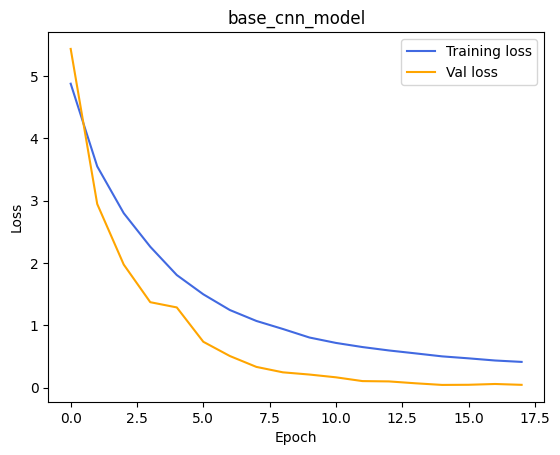

In [53]:
# Plot total loss
plt.figure()
plt.title(f"{model_name}")
plt.plot(history.history['loss'], label='Training loss', color = 'royalblue')
plt.plot(history.history['val_loss'], label='Val loss', color = 'orange')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

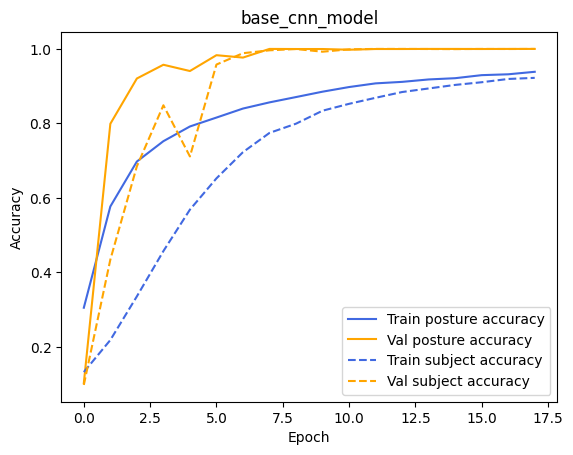

In [54]:
# Plot posture and subject accuracy
plt.figure()
plt.title(f"{model_name}")
plt.plot(history.history['posture_output_categorical_accuracy'], label='Train posture accuracy', color='royalblue')
plt.plot(history.history['val_posture_output_categorical_accuracy'], label='Val posture accuracy', color='orange')
plt.plot(history.history['subject_output_categorical_accuracy'], label='Train subject accuracy', color='royalblue', linestyle='--')
plt.plot(history.history['val_subject_output_categorical_accuracy'], label='Val subject accuracy', color='orange', linestyle='--')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Final Model Testing

Model: "base_cnn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 62, 30, 32)   320         ['img[0][0]']                    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 62, 30, 32)  128         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 31, 15, 32)  0           ['batch_normalizatio

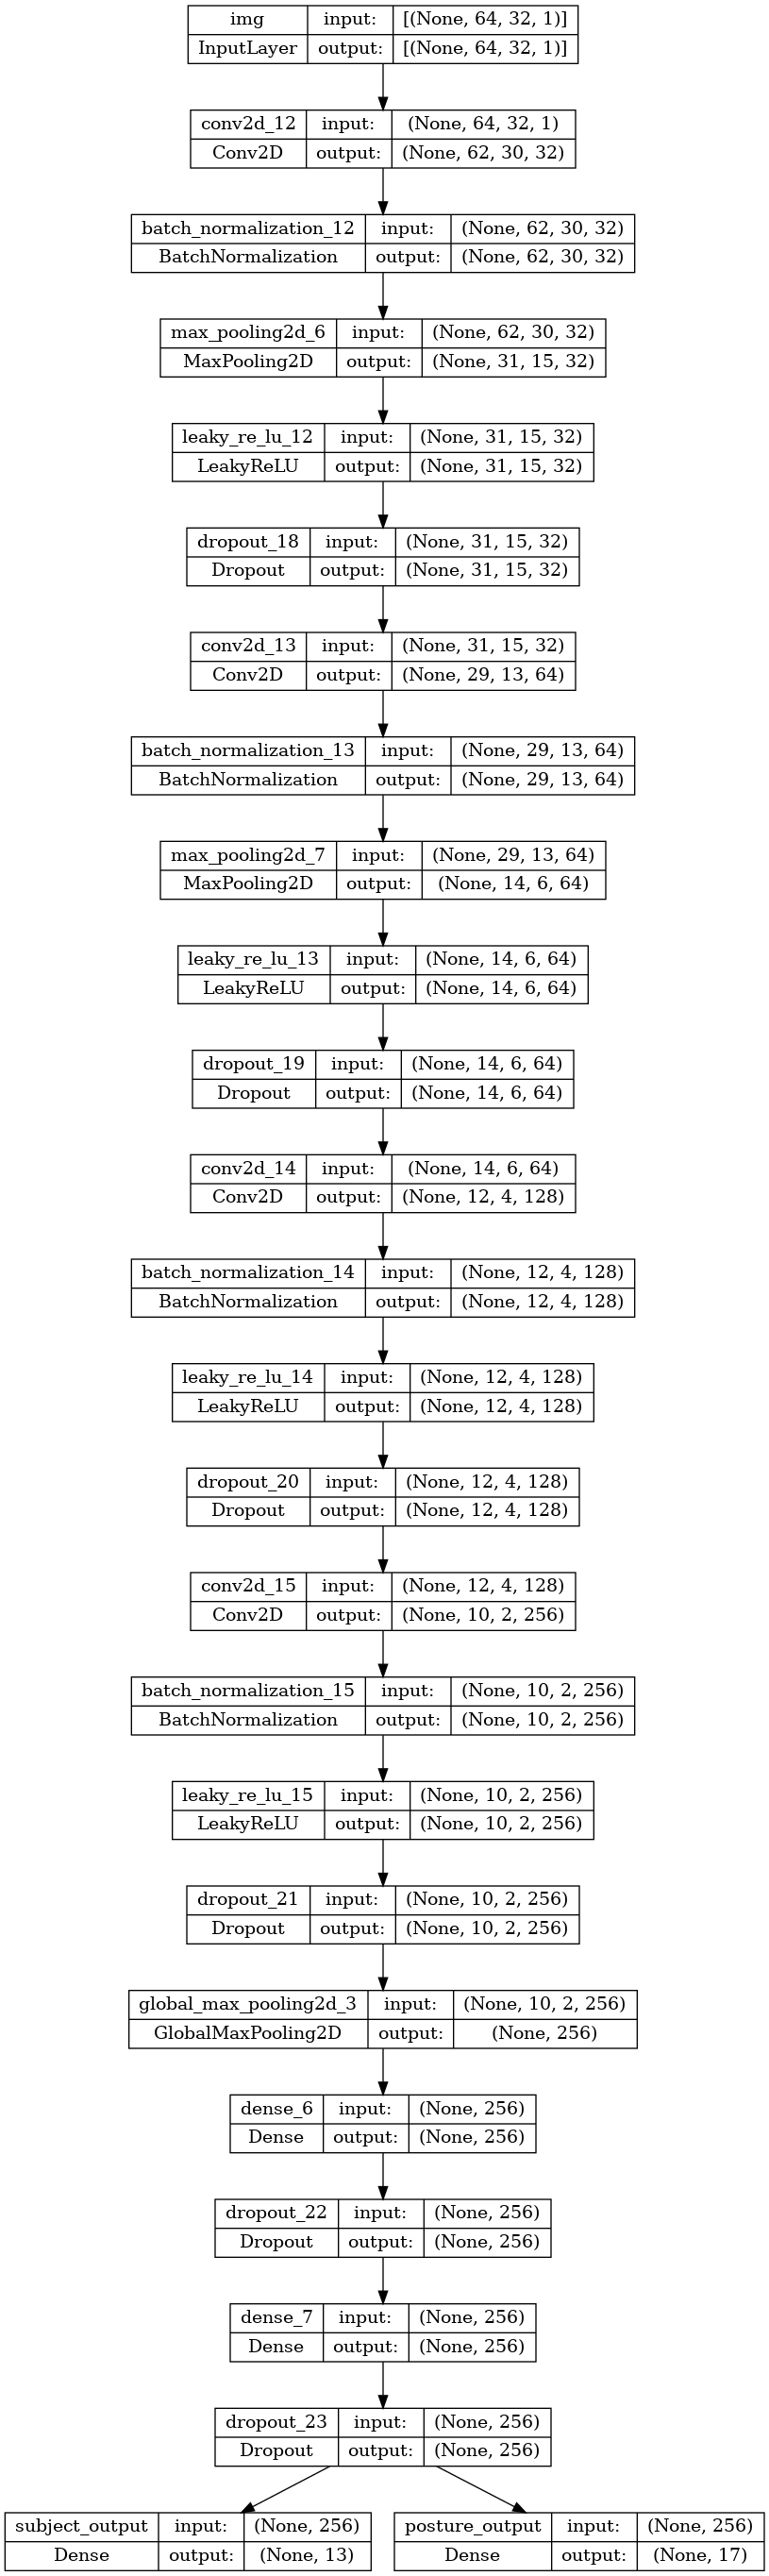

In [49]:
# Summary and plot of the model
model.summary()
plot_model(model, show_shapes=True)

In [128]:
print(f'Predict the classification of {X_test.shape[0]} samples')
y_pred_subject, y_pred_posture = model.predict(X_test)

# Determine the predicted classes using argmax
y_pred_posture = np.argmax(y_pred_posture, axis=1)
y_pred_subject = np.argmax(y_pred_subject, axis=1)

Predict the classification of 1870 samples
59/59 [==============================] - 0s 2ms/step


### Confusion Matrices

In [129]:
# Sort position labels: supine, right, left

positions_ii_sorted = ['supine', 'supine_star', 'supine_hand_crossed', 'supine_knees_up', 'supine_right_knee_up', 'supine_left_knee_up',  
                       'supine_30_inclination', 'supine_45_inclination', 'supine_60_inclination',
                       'right', 'right_30_roll', 'right_60_roll', 'right_fetus',
                       'left', 'left_30_roll', 'left_60_roll', 'left_fetus'
                       ]

# indices of the sorted positions
positions_ii_sorted_indices = [positions_ii.index(position)-1 for position in positions_ii_sorted]

In [130]:
# Extract true labels of posture and subject
y_true = np.argmax(y_test, axis=1)
label_s_true = np.argmax(label_s_test, axis=1)

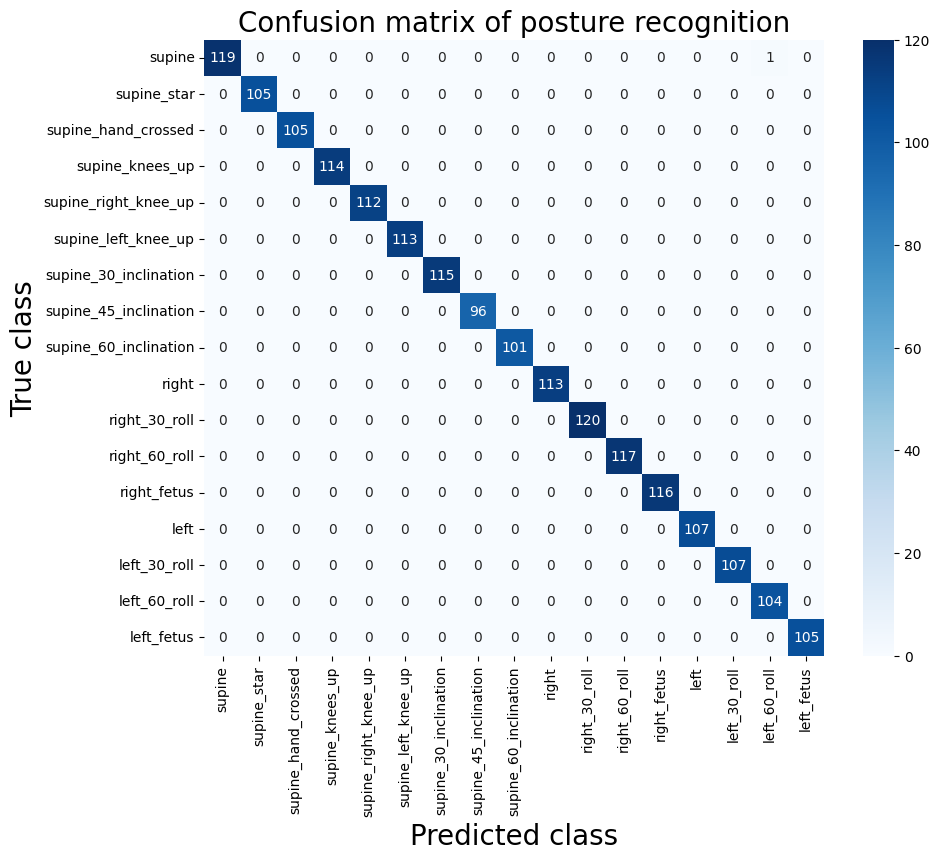

In [131]:
posture_cm = confusion_matrix(y_true=y_true, y_pred=y_pred_posture, labels=positions_ii_sorted_indices)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(posture_cm, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(positions_ii_sorted, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True class', fontsize=20)
ax.yaxis.set_ticklabels(positions_ii_sorted, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion matrix of posture recognition', fontsize=20)

plt.show()
     

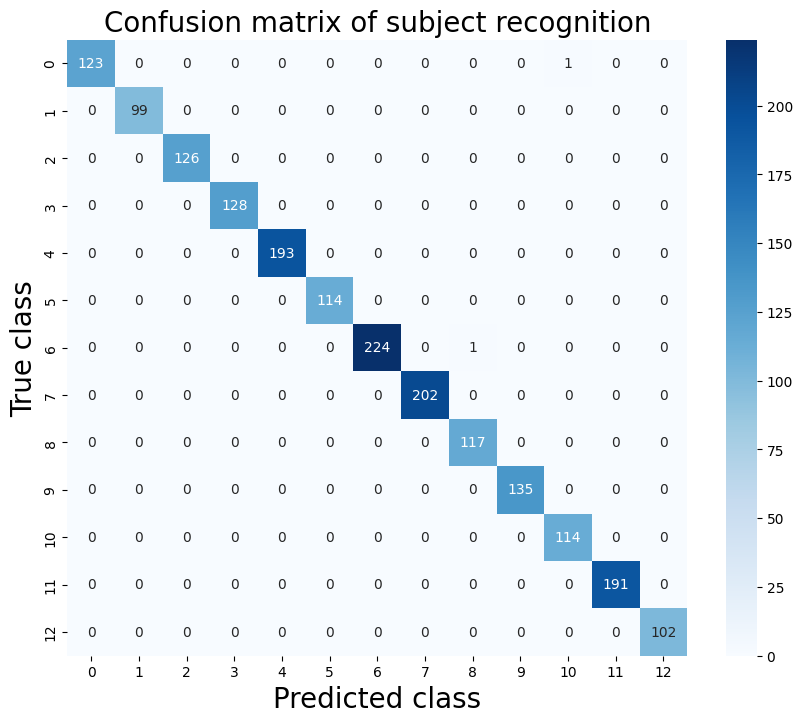

In [132]:
subject_cm = confusion_matrix(y_true=label_s_true, y_pred=y_pred_subject)

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.heatmap(subject_cm, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.set_ylabel('True class', fontsize=20)
plt.title('Confusion matrix of subject recognition', fontsize=20)
plt.show()

### Performance Metrics - Accuracy, Recall, Precision, F1-Score

In [133]:
# Accuracy, Precision, Recall, F1-Score
posture_accuracy = accuracy_score(y_true, y_pred_posture)
subject_accuracy = accuracy_score(label_s_true, y_pred_subject)

posture_precision, posture_recall, posture_fscore, _ = precision_recall_fscore_support(y_true, y_pred_posture)
subject_precision, subject_recall, subject_fscore, _ = precision_recall_fscore_support(label_s_true, y_pred_subject)

# Create a DataFrame to display the results
results = pd.DataFrame(index=['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score'])

# Add the results to the DataFrame
results['Posture'] = [np.round(posture_accuracy,3), 
                      np.round(np.mean(posture_precision),3), 
                      np.round(np.mean(posture_recall),3), 
                      np.round(np.mean(posture_fscore),3)]

results['Subject'] = [np.round(subject_accuracy,3),
                      np.round(np.mean(subject_precision),3),
                      np.round(np.mean(subject_recall),3),
                      np.round(np.mean(subject_fscore),3)]

results

,Posture,Subject
Accuracy (%),0.999,0.999
Precision (%),0.999,0.999
Recall (%),1.000,0.999
F1-Score,0.999,0.999


### Accuracy for each Macro Position

In [134]:
left_correct = 0
left_incorrect = 0

right_correct = 0
right_incorrect = 0

supine_correct = 0
supine_incorrect = 0

# left
for i in range(0, 4):
    for j in range(0, 4):
        left_correct += posture_cm[i][j]
    for j in range(4, 17):
        left_incorrect += posture_cm[i][j]

# right
for i in range(4, 8):
    for j in range(4, 8):
        right_correct += posture_cm[i][j]
    for j in range(0, 4):
        right_incorrect += posture_cm[i][j]
    for j in range(8, 17):
        right_incorrect += posture_cm[i][j]

# supine
for i in range(8, 17):
    for j in range(8, 17):
        supine_correct += posture_cm[i][j]
    for j in range(0, 8):
        supine_incorrect += posture_cm[i][j]

total_incorrect = left_incorrect + right_incorrect + supine_incorrect

print(f"Left: Correct: {left_correct}, Incorrect: {left_incorrect}")
print(f"Right: Correct: {right_correct}, Incorrect: {right_incorrect}")
print(f"Supine: Correct: {supine_correct}, Incorrect: {supine_incorrect}")
print(f"Total Incorrect: {total_incorrect}")

left_accuracy = round(left_correct/(left_correct+left_incorrect), 2)
right_accuracy = round(right_correct/(right_correct+right_incorrect), 2)
supine_accuracy = round(supine_correct/(supine_correct+supine_incorrect), 2)

# print accuracy
print(f"Left: {left_accuracy}")
print(f"Right: {right_accuracy}")
print(f"Supine: {right_accuracy}")

print("Number of images misclassified: ", total_incorrect)

Left: Correct: 443, Incorrect: 1
Right: Correct: 436, Incorrect: 0
Supine: Correct: 990, Incorrect: 0
Total Incorrect: 1
Left: 1.0
Right: 1.0
Supine: 1.0
Number of images misclassified:  1


### K-Fold Cross Validation

In [46]:
# One-hot encode the labels
num_postures = 17

label_s_oh = tf.keras.utils.to_categorical(label_s, num_classes=13)
y_oh = tf.keras.utils.to_categorical(y, num_classes=num_postures)

In [47]:
# K-Fold Cross Validation on best model

initial_learning_rate = 5e-4
epochs = 40
batch_size = 32
regularization = 0
model_name = 'best_model'

lambda_performance = pd.DataFrame(index=['Test Subject Accuracy', 'Test Posture Accuracy', 'Training Time (s)'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

skf = StratifiedKFold(n_splits=10, shuffle=True)

lambdas = [0.2, 0.5, 0.6, 0.8]

performances = {lambd: [] for lambd in lambdas}
for lambd in lambdas:
    performances[lambd] = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Lambda: {lambd} Fold {i}:")
        model=create_model(num_postures, regularization) # For now, this is the best model
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        model.compile(optimizer = optimizer,
                loss= {'subject_output': 'categorical_crossentropy',
                'posture_output': 'categorical_crossentropy'},
                loss_weights = {'subject_output': lambd_val,
                        'posture_output': 1-lambd_val},
                metrics=[tf.keras.metrics.CategoricalAccuracy()])

        start_time = time.time()

        history = model.fit(
            X[train_index], 
            {
                'subject_output': label_s_oh[train_index], 
                'posture_output': y_oh[train_index]
            },
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(
                X[test_index], 
                {
                    'subject_output': label_s_oh[test_index], 
                    'posture_output': y_oh[test_index]
                }
            ),
            callbacks=[early_stop_callback]
        )

        end_time = time.time()
        training_time = end_time - start_time
        
        # Record the model performance per fold and lambda
        performances[lambd].append([
                                    history.history["val_subject_output_categorical_accuracy"], 
                                    history.history["val_posture_output_categorical_accuracy"],
                                    training_time
                                    ])


# mean performances for each lamda on subject [0] or posture [1] accuracy
for lambd in lambdas:
    subject_accuracies = [perf[0] for perf in performances[lambd]]
    posture_accuracies = [perf[1] for perf in performances[lambd]]
    training_times = [perf[2] for perf in performances[lambd]]
    
    # Calculate the maximum accuracy for each fold across all epochs
    max_subject_accuracies = [np.max(fold_accuracies) for fold_accuracies in subject_accuracies]
    max_posture_accuracies = [np.max(fold_accuracies) for fold_accuracies in posture_accuracies]
    
    # Calculate the mean of these maximum accuracies over folds
    mean_max_subject_accuracy = np.round(np.mean(max_subject_accuracies), 3)
    mean_max_posture_accuracy = np.round(np.mean(max_posture_accuracies), 3)
    mean_training_time = np.round(np.mean(training_times), 3)
    
    # Append the results to the DataFrame
    lambda_performance[lambd] = [mean_max_subject_accuracy, mean_max_posture_accuracy,mean_training_time]

Lambda: 0.2 Fold 0:
Epoch 1/40


2024-07-07 22:33:43.923213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_312/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0973 - subject_output_loss: 2.7387 - posture_output_loss: 1.8224 - subject_output_categorical_accuracy: 0.1384 - posture_output_categorical_accuracy: 0.4176 - val_loss: 1.2682 - val_subject_output_loss: 2.2737 - val_posture_output_loss: 0.8372 - val_subject_output_categorical_accuracy: 0.2754 - val_posture_output_categorical_accuracy: 0.7973
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1885 - subject_output_loss: 2.3492 - posture_output_loss: 0.6911 - subject_output_categorical_accuracy: 0.2328 - posture_output_categorical_accuracy: 0.7458 - val_loss: 0.8134 - val_subject_output_loss: 1.9170 - val_posture_output_loss: 0.3404 - val_subject_output_categorical_accuracy: 0.3850 - val_posture_output_categorical_accuracy: 0.9102
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8767 - subject_output_loss: 1.9814 - posture_output_loss: 0.4033 - subject_output_categorical_a

2024-07-07 22:35:29.603461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_318/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0979 - subject_output_loss: 2.6916 - posture_output_loss: 1.8435 - subject_output_categorical_accuracy: 0.1443 - posture_output_categorical_accuracy: 0.3964 - val_loss: 1.2975 - val_subject_output_loss: 2.2760 - val_posture_output_loss: 0.8782 - val_subject_output_categorical_accuracy: 0.2807 - val_posture_output_categorical_accuracy: 0.7898
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.2047 - subject_output_loss: 2.3339 - posture_output_loss: 0.7208 - subject_output_categorical_accuracy: 0.2371 - posture_output_categorical_accuracy: 0.7334 - val_loss: 0.8081 - val_subject_output_loss: 1.9274 - val_posture_output_loss: 0.3284 - val_subject_output_categorical_accuracy: 0.4775 - val_posture_output_categorical_accuracy: 0.9492
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8929 - subject_output_loss: 2.0170 - posture_output_loss: 0.4111 - subject_output_categorical_a

2024-07-07 22:37:16.488490: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_324/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 5s 5ms/step - loss: 2.0746 - subject_output_loss: 2.7291 - posture_output_loss: 1.7940 - subject_output_categorical_accuracy: 0.1493 - posture_output_categorical_accuracy: 0.4143 - val_loss: 1.2524 - val_subject_output_loss: 2.3016 - val_posture_output_loss: 0.8027 - val_subject_output_categorical_accuracy: 0.2428 - val_posture_output_categorical_accuracy: 0.7925
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1556 - subject_output_loss: 2.3159 - posture_output_loss: 0.6584 - subject_output_categorical_accuracy: 0.2420 - posture_output_categorical_accuracy: 0.7609 - val_loss: 0.7655 - val_subject_output_loss: 1.8659 - val_posture_output_loss: 0.2938 - val_subject_output_categorical_accuracy: 0.4882 - val_posture_output_categorical_accuracy: 0.9481
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8483 - subject_output_loss: 1.9645 - posture_output_loss: 0.3699 - subject_output_categorical_a

2024-07-07 22:38:51.746737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_330/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0969 - subject_output_loss: 2.6688 - posture_output_loss: 1.8518 - subject_output_categorical_accuracy: 0.1467 - posture_output_categorical_accuracy: 0.3959 - val_loss: 1.3348 - val_subject_output_loss: 2.2707 - val_posture_output_loss: 0.9337 - val_subject_output_categorical_accuracy: 0.2588 - val_posture_output_categorical_accuracy: 0.7652
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.2055 - subject_output_loss: 2.3397 - posture_output_loss: 0.7194 - subject_output_categorical_accuracy: 0.2357 - posture_output_categorical_accuracy: 0.7375 - val_loss: 0.8456 - val_subject_output_loss: 1.9676 - val_posture_output_loss: 0.3647 - val_subject_output_categorical_accuracy: 0.3893 - val_posture_output_categorical_accuracy: 0.8925
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8992 - subject_output_loss: 2.0223 - posture_output_loss: 0.4179 - subject_output_categorical_a

2024-07-07 22:40:43.570221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_336/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0815 - subject_output_loss: 2.6856 - posture_output_loss: 1.8226 - subject_output_categorical_accuracy: 0.1603 - posture_output_categorical_accuracy: 0.4106 - val_loss: 1.3218 - val_subject_output_loss: 2.2602 - val_posture_output_loss: 0.9197 - val_subject_output_categorical_accuracy: 0.2519 - val_posture_output_categorical_accuracy: 0.7551
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1675 - subject_output_loss: 2.2701 - posture_output_loss: 0.6949 - subject_output_categorical_accuracy: 0.2507 - posture_output_categorical_accuracy: 0.7434 - val_loss: 0.7670 - val_subject_output_loss: 1.8134 - val_posture_output_loss: 0.3185 - val_subject_output_categorical_accuracy: 0.5080 - val_posture_output_categorical_accuracy: 0.9380
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8782 - subject_output_loss: 1.9462 - posture_output_loss: 0.4205 - subject_output_categorical_a

2024-07-07 22:42:35.265568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_342/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0278 - subject_output_loss: 2.6744 - posture_output_loss: 1.7507 - subject_output_categorical_accuracy: 0.1433 - posture_output_categorical_accuracy: 0.4307 - val_loss: 1.1533 - val_subject_output_loss: 2.1865 - val_posture_output_loss: 0.7105 - val_subject_output_categorical_accuracy: 0.3150 - val_posture_output_categorical_accuracy: 0.7856
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1519 - subject_output_loss: 2.3112 - posture_output_loss: 0.6550 - subject_output_categorical_accuracy: 0.2373 - posture_output_categorical_accuracy: 0.7586 - val_loss: 0.7614 - val_subject_output_loss: 1.8894 - val_posture_output_loss: 0.2780 - val_subject_output_categorical_accuracy: 0.4150 - val_posture_output_categorical_accuracy: 0.9540
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8600 - subject_output_loss: 1.9828 - posture_output_loss: 0.3788 - subject_output_categorical_a

2024-07-07 22:44:04.741947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_348/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0243 - subject_output_loss: 2.7089 - posture_output_loss: 1.7309 - subject_output_categorical_accuracy: 0.1453 - posture_output_categorical_accuracy: 0.4391 - val_loss: 1.2203 - val_subject_output_loss: 2.2787 - val_posture_output_loss: 0.7667 - val_subject_output_categorical_accuracy: 0.2786 - val_posture_output_categorical_accuracy: 0.8059
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1386 - subject_output_loss: 2.3446 - posture_output_loss: 0.6217 - subject_output_categorical_accuracy: 0.2306 - posture_output_categorical_accuracy: 0.7753 - val_loss: 0.7954 - val_subject_output_loss: 2.0249 - val_posture_output_loss: 0.2685 - val_subject_output_categorical_accuracy: 0.3615 - val_posture_output_categorical_accuracy: 0.9610
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8415 - subject_output_loss: 1.9981 - posture_output_loss: 0.3458 - subject_output_categorical_a

2024-07-07 22:45:21.549745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_354/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0529 - subject_output_loss: 2.6828 - posture_output_loss: 1.7829 - subject_output_categorical_accuracy: 0.1552 - posture_output_categorical_accuracy: 0.4159 - val_loss: 1.2606 - val_subject_output_loss: 2.2077 - val_posture_output_loss: 0.8547 - val_subject_output_categorical_accuracy: 0.3294 - val_posture_output_categorical_accuracy: 0.7882
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1609 - subject_output_loss: 2.2602 - posture_output_loss: 0.6897 - subject_output_categorical_accuracy: 0.2576 - posture_output_categorical_accuracy: 0.7502 - val_loss: 0.7771 - val_subject_output_loss: 1.8073 - val_posture_output_loss: 0.3357 - val_subject_output_categorical_accuracy: 0.4995 - val_posture_output_categorical_accuracy: 0.9524
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8483 - subject_output_loss: 1.9398 - posture_output_loss: 0.3805 - subject_output_categorical_a

2024-07-07 22:46:25.460983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_360/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0858 - subject_output_loss: 2.6912 - posture_output_loss: 1.8264 - subject_output_categorical_accuracy: 0.1594 - posture_output_categorical_accuracy: 0.4159 - val_loss: 1.2045 - val_subject_output_loss: 2.1952 - val_posture_output_loss: 0.7799 - val_subject_output_categorical_accuracy: 0.3189 - val_posture_output_categorical_accuracy: 0.8352
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1464 - subject_output_loss: 2.2546 - posture_output_loss: 0.6715 - subject_output_categorical_accuracy: 0.2577 - posture_output_categorical_accuracy: 0.7556 - val_loss: 0.7189 - val_subject_output_loss: 1.7865 - val_posture_output_loss: 0.2614 - val_subject_output_categorical_accuracy: 0.4981 - val_posture_output_categorical_accuracy: 0.9604
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8240 - subject_output_loss: 1.9118 - posture_output_loss: 0.3578 - subject_output_categorical_a

2024-07-07 22:47:41.044432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_366/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0652 - subject_output_loss: 2.6854 - posture_output_loss: 1.7994 - subject_output_categorical_accuracy: 0.1549 - posture_output_categorical_accuracy: 0.4272 - val_loss: 1.2978 - val_subject_output_loss: 2.2525 - val_posture_output_loss: 0.8887 - val_subject_output_categorical_accuracy: 0.3012 - val_posture_output_categorical_accuracy: 0.7673
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1571 - subject_output_loss: 2.2688 - posture_output_loss: 0.6806 - subject_output_categorical_accuracy: 0.2521 - posture_output_categorical_accuracy: 0.7484 - val_loss: 0.7755 - val_subject_output_loss: 1.8465 - val_posture_output_loss: 0.3166 - val_subject_output_categorical_accuracy: 0.4152 - val_posture_output_categorical_accuracy: 0.9411
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8609 - subject_output_loss: 1.9534 - posture_output_loss: 0.3927 - subject_output_categorical_a

2024-07-07 22:48:51.252206: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_372/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0003 - subject_output_loss: 2.7130 - posture_output_loss: 1.6948 - subject_output_categorical_accuracy: 0.1502 - posture_output_categorical_accuracy: 0.4547 - val_loss: 1.1007 - val_subject_output_loss: 2.1759 - val_posture_output_loss: 0.6399 - val_subject_output_categorical_accuracy: 0.3225 - val_posture_output_categorical_accuracy: 0.8701
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1219 - subject_output_loss: 2.2936 - posture_output_loss: 0.6198 - subject_output_categorical_accuracy: 0.2488 - posture_output_categorical_accuracy: 0.7762 - val_loss: 0.7202 - val_subject_output_loss: 1.8456 - val_posture_output_loss: 0.2379 - val_subject_output_categorical_accuracy: 0.5027 - val_posture_output_categorical_accuracy: 0.9572
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8254 - subject_output_loss: 1.9510 - posture_output_loss: 0.3430 - subject_output_categorical_a

2024-07-07 22:50:26.616474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_378/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 7s 8ms/step - loss: 2.0456 - subject_output_loss: 2.7083 - posture_output_loss: 1.7616 - subject_output_categorical_accuracy: 0.1413 - posture_output_categorical_accuracy: 0.4318 - val_loss: 1.2207 - val_subject_output_loss: 2.2440 - val_posture_output_loss: 0.7822 - val_subject_output_categorical_accuracy: 0.3187 - val_posture_output_categorical_accuracy: 0.8257
Epoch 2/40
526/526 [==============================] - 4s 7ms/step - loss: 1.1669 - subject_output_loss: 2.3272 - posture_output_loss: 0.6695 - subject_output_categorical_accuracy: 0.2390 - posture_output_categorical_accuracy: 0.7536 - val_loss: 0.7969 - val_subject_output_loss: 1.9376 - val_posture_output_loss: 0.3081 - val_subject_output_categorical_accuracy: 0.3893 - val_posture_output_categorical_accuracy: 0.9273
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8794 - subject_output_loss: 1.9912 - posture_output_loss: 0.4029 - subject_output_categorical_a

2024-07-07 22:52:27.232981: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_384/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 7s 7ms/step - loss: 2.0248 - subject_output_loss: 2.7087 - posture_output_loss: 1.7318 - subject_output_categorical_accuracy: 0.1474 - posture_output_categorical_accuracy: 0.4392 - val_loss: 1.1429 - val_subject_output_loss: 2.1985 - val_posture_output_loss: 0.6905 - val_subject_output_categorical_accuracy: 0.3433 - val_posture_output_categorical_accuracy: 0.8299
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1469 - subject_output_loss: 2.2721 - posture_output_loss: 0.6646 - subject_output_categorical_accuracy: 0.2554 - posture_output_categorical_accuracy: 0.7573 - val_loss: 0.7744 - val_subject_output_loss: 1.8411 - val_posture_output_loss: 0.3172 - val_subject_output_categorical_accuracy: 0.4813 - val_posture_output_categorical_accuracy: 0.9449
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8375 - subject_output_loss: 1.9291 - posture_output_loss: 0.3696 - subject_output_categorical_a

2024-07-07 22:54:22.507503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_390/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0485 - subject_output_loss: 2.7048 - posture_output_loss: 1.7673 - subject_output_categorical_accuracy: 0.1432 - posture_output_categorical_accuracy: 0.4267 - val_loss: 1.2594 - val_subject_output_loss: 2.2660 - val_posture_output_loss: 0.8280 - val_subject_output_categorical_accuracy: 0.2813 - val_posture_output_categorical_accuracy: 0.7813
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1777 - subject_output_loss: 2.3321 - posture_output_loss: 0.6830 - subject_output_categorical_accuracy: 0.2357 - posture_output_categorical_accuracy: 0.7524 - val_loss: 0.7721 - val_subject_output_loss: 1.8794 - val_posture_output_loss: 0.2976 - val_subject_output_categorical_accuracy: 0.4717 - val_posture_output_categorical_accuracy: 0.9561
Epoch 3/40
526/526 [==============================] - 3s 5ms/step - loss: 0.8647 - subject_output_loss: 1.9777 - posture_output_loss: 0.3877 - subject_output_categorical_a

2024-07-07 22:55:46.033418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_396/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0941 - subject_output_loss: 2.7047 - posture_output_loss: 1.8324 - subject_output_categorical_accuracy: 0.1571 - posture_output_categorical_accuracy: 0.4070 - val_loss: 1.2890 - val_subject_output_loss: 2.2678 - val_posture_output_loss: 0.8695 - val_subject_output_categorical_accuracy: 0.2834 - val_posture_output_categorical_accuracy: 0.8086
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.2049 - subject_output_loss: 2.3276 - posture_output_loss: 0.7238 - subject_output_categorical_accuracy: 0.2450 - posture_output_categorical_accuracy: 0.7313 - val_loss: 0.8290 - val_subject_output_loss: 1.9106 - val_posture_output_loss: 0.3654 - val_subject_output_categorical_accuracy: 0.4364 - val_posture_output_categorical_accuracy: 0.9123
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8999 - subject_output_loss: 2.0114 - posture_output_loss: 0.4236 - subject_output_categorical_a

2024-07-07 22:57:06.274833: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_402/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0865 - subject_output_loss: 2.6733 - posture_output_loss: 1.8350 - subject_output_categorical_accuracy: 0.1456 - posture_output_categorical_accuracy: 0.4027 - val_loss: 1.3189 - val_subject_output_loss: 2.2913 - val_posture_output_loss: 0.9022 - val_subject_output_categorical_accuracy: 0.2364 - val_posture_output_categorical_accuracy: 0.7791
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.2151 - subject_output_loss: 2.3452 - posture_output_loss: 0.7307 - subject_output_categorical_accuracy: 0.2355 - posture_output_categorical_accuracy: 0.7339 - val_loss: 0.8286 - val_subject_output_loss: 1.9691 - val_posture_output_loss: 0.3397 - val_subject_output_categorical_accuracy: 0.4219 - val_posture_output_categorical_accuracy: 0.9198
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.9035 - subject_output_loss: 2.0354 - posture_output_loss: 0.4184 - subject_output_categorical_a

2024-07-07 22:58:48.254863: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_408/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 5s 5ms/step - loss: 2.0702 - subject_output_loss: 2.6597 - posture_output_loss: 1.8175 - subject_output_categorical_accuracy: 0.1544 - posture_output_categorical_accuracy: 0.4044 - val_loss: 1.2553 - val_subject_output_loss: 2.2380 - val_posture_output_loss: 0.8341 - val_subject_output_categorical_accuracy: 0.2866 - val_posture_output_categorical_accuracy: 0.7599
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1647 - subject_output_loss: 2.3074 - posture_output_loss: 0.6750 - subject_output_categorical_accuracy: 0.2433 - posture_output_categorical_accuracy: 0.7572 - val_loss: 0.7789 - val_subject_output_loss: 1.9386 - val_posture_output_loss: 0.2820 - val_subject_output_categorical_accuracy: 0.3652 - val_posture_output_categorical_accuracy: 0.9294
Epoch 3/40
526/526 [==============================] - 4s 7ms/step - loss: 0.8424 - subject_output_loss: 2.0017 - posture_output_loss: 0.3455 - subject_output_categorical_a

2024-07-07 23:00:16.640837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_414/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0329 - subject_output_loss: 2.6842 - posture_output_loss: 1.7537 - subject_output_categorical_accuracy: 0.1512 - posture_output_categorical_accuracy: 0.4270 - val_loss: 1.2834 - val_subject_output_loss: 2.3173 - val_posture_output_loss: 0.8404 - val_subject_output_categorical_accuracy: 0.2455 - val_posture_output_categorical_accuracy: 0.7829
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1795 - subject_output_loss: 2.3423 - posture_output_loss: 0.6812 - subject_output_categorical_accuracy: 0.2303 - posture_output_categorical_accuracy: 0.7506 - val_loss: 0.8086 - val_subject_output_loss: 1.9279 - val_posture_output_loss: 0.3289 - val_subject_output_categorical_accuracy: 0.4390 - val_posture_output_categorical_accuracy: 0.9257
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8738 - subject_output_loss: 2.0127 - posture_output_loss: 0.3857 - subject_output_categorical_a

2024-07-07 23:02:10.625508: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_420/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 7s 6ms/step - loss: 2.0708 - subject_output_loss: 2.6818 - posture_output_loss: 1.8089 - subject_output_categorical_accuracy: 0.1555 - posture_output_categorical_accuracy: 0.4072 - val_loss: 1.2352 - val_subject_output_loss: 2.1942 - val_posture_output_loss: 0.8242 - val_subject_output_categorical_accuracy: 0.2884 - val_posture_output_categorical_accuracy: 0.7630
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1839 - subject_output_loss: 2.2787 - posture_output_loss: 0.7148 - subject_output_categorical_accuracy: 0.2467 - posture_output_categorical_accuracy: 0.7419 - val_loss: 0.7952 - val_subject_output_loss: 1.9154 - val_posture_output_loss: 0.3151 - val_subject_output_categorical_accuracy: 0.4114 - val_posture_output_categorical_accuracy: 0.9492
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8720 - subject_output_loss: 1.9877 - posture_output_loss: 0.3938 - subject_output_categorical_a

2024-07-07 23:04:03.577537: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_426/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 5s 5ms/step - loss: 2.0866 - subject_output_loss: 2.6790 - posture_output_loss: 1.8327 - subject_output_categorical_accuracy: 0.1499 - posture_output_categorical_accuracy: 0.4096 - val_loss: 1.2711 - val_subject_output_loss: 2.2810 - val_posture_output_loss: 0.8383 - val_subject_output_categorical_accuracy: 0.2349 - val_posture_output_categorical_accuracy: 0.7683
Epoch 2/40
526/526 [==============================] - 3s 5ms/step - loss: 1.1982 - subject_output_loss: 2.3524 - posture_output_loss: 0.7035 - subject_output_categorical_accuracy: 0.2324 - posture_output_categorical_accuracy: 0.7447 - val_loss: 0.8334 - val_subject_output_loss: 2.0259 - val_posture_output_loss: 0.3223 - val_subject_output_categorical_accuracy: 0.3023 - val_posture_output_categorical_accuracy: 0.9128
Epoch 3/40
526/526 [==============================] - 3s 6ms/step - loss: 0.8918 - subject_output_loss: 2.0454 - posture_output_loss: 0.3974 - subject_output_categorical_a

2024-07-07 23:07:06.851772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_432/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 12s 17ms/step - loss: 2.0582 - subject_output_loss: 2.6827 - posture_output_loss: 1.7905 - subject_output_categorical_accuracy: 0.1553 - posture_output_categorical_accuracy: 0.4157 - val_loss: 1.2265 - val_subject_output_loss: 2.2390 - val_posture_output_loss: 0.7926 - val_subject_output_categorical_accuracy: 0.3139 - val_posture_output_categorical_accuracy: 0.8027
Epoch 2/40
526/526 [==============================] - 9s 16ms/step - loss: 1.1703 - subject_output_loss: 2.3029 - posture_output_loss: 0.6849 - subject_output_categorical_accuracy: 0.2418 - posture_output_categorical_accuracy: 0.7490 - val_loss: 0.8060 - val_subject_output_loss: 1.8852 - val_posture_output_loss: 0.3434 - val_subject_output_categorical_accuracy: 0.4059 - val_posture_output_categorical_accuracy: 0.9155
Epoch 3/40
526/526 [==============================] - 8s 16ms/step - loss: 0.8944 - subject_output_loss: 1.9915 - posture_output_loss: 0.4242 - subject_output_categoric

2024-07-07 23:12:07.852373: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_438/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 11s 16ms/step - loss: 2.0669 - subject_output_loss: 2.6956 - posture_output_loss: 1.7975 - subject_output_categorical_accuracy: 0.1484 - posture_output_categorical_accuracy: 0.4217 - val_loss: 1.2587 - val_subject_output_loss: 2.2464 - val_posture_output_loss: 0.8354 - val_subject_output_categorical_accuracy: 0.3053 - val_posture_output_categorical_accuracy: 0.8198
Epoch 2/40
526/526 [==============================] - 8s 16ms/step - loss: 1.1642 - subject_output_loss: 2.3111 - posture_output_loss: 0.6726 - subject_output_categorical_accuracy: 0.2438 - posture_output_categorical_accuracy: 0.7539 - val_loss: 0.7612 - val_subject_output_loss: 1.8518 - val_posture_output_loss: 0.2937 - val_subject_output_categorical_accuracy: 0.4840 - val_posture_output_categorical_accuracy: 0.9476
Epoch 3/40
526/526 [==============================] - 8s 16ms/step - loss: 0.8599 - subject_output_loss: 1.9568 - posture_output_loss: 0.3898 - subject_output_categoric

2024-07-07 23:15:31.404834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_444/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 6ms/step - loss: 2.0936 - subject_output_loss: 2.6750 - posture_output_loss: 1.8445 - subject_output_categorical_accuracy: 0.1509 - posture_output_categorical_accuracy: 0.4040 - val_loss: 1.2709 - val_subject_output_loss: 2.2017 - val_posture_output_loss: 0.8720 - val_subject_output_categorical_accuracy: 0.3246 - val_posture_output_categorical_accuracy: 0.8011
Epoch 2/40
526/526 [==============================] - 3s 6ms/step - loss: 1.1970 - subject_output_loss: 2.2824 - posture_output_loss: 0.7318 - subject_output_categorical_accuracy: 0.2448 - posture_output_categorical_accuracy: 0.7309 - val_loss: 0.8021 - val_subject_output_loss: 1.8476 - val_posture_output_loss: 0.3541 - val_subject_output_categorical_accuracy: 0.4882 - val_posture_output_categorical_accuracy: 0.9171
Epoch 3/40
526/526 [==============================] - 4s 7ms/step - loss: 0.8702 - subject_output_loss: 1.9746 - posture_output_loss: 0.3969 - subject_output_categorical_a

2024-07-07 23:19:27.781846: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_450/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 11s 16ms/step - loss: 2.0540 - subject_output_loss: 2.6623 - posture_output_loss: 1.7934 - subject_output_categorical_accuracy: 0.1527 - posture_output_categorical_accuracy: 0.4188 - val_loss: 1.2600 - val_subject_output_loss: 2.2102 - val_posture_output_loss: 0.8527 - val_subject_output_categorical_accuracy: 0.2636 - val_posture_output_categorical_accuracy: 0.7561
Epoch 2/40
526/526 [==============================] - 8s 16ms/step - loss: 1.1760 - subject_output_loss: 2.2669 - posture_output_loss: 0.7084 - subject_output_categorical_accuracy: 0.2471 - posture_output_categorical_accuracy: 0.7363 - val_loss: 0.8026 - val_subject_output_loss: 1.8404 - val_posture_output_loss: 0.3578 - val_subject_output_categorical_accuracy: 0.4599 - val_posture_output_categorical_accuracy: 0.9086
Epoch 3/40
526/526 [==============================] - 8s 16ms/step - loss: 0.8894 - subject_output_loss: 1.9613 - posture_output_loss: 0.4301 - subject_output_categoric

2024-07-07 23:23:46.109095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_456/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 12s 17ms/step - loss: 2.0498 - subject_output_loss: 2.6721 - posture_output_loss: 1.7831 - subject_output_categorical_accuracy: 0.1562 - posture_output_categorical_accuracy: 0.4215 - val_loss: 1.1910 - val_subject_output_loss: 2.2139 - val_posture_output_loss: 0.7527 - val_subject_output_categorical_accuracy: 0.3155 - val_posture_output_categorical_accuracy: 0.7856
Epoch 2/40
526/526 [==============================] - 8s 16ms/step - loss: 1.1454 - subject_output_loss: 2.2781 - posture_output_loss: 0.6599 - subject_output_categorical_accuracy: 0.2487 - posture_output_categorical_accuracy: 0.7606 - val_loss: 0.7607 - val_subject_output_loss: 1.8096 - val_posture_output_loss: 0.3112 - val_subject_output_categorical_accuracy: 0.5337 - val_posture_output_categorical_accuracy: 0.8930
Epoch 3/40
526/526 [==============================] - 8s 16ms/step - loss: 0.8247 - subject_output_loss: 1.9000 - posture_output_loss: 0.3639 - subject_output_categoric

2024-07-07 23:28:36.812559: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_462/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 11s 16ms/step - loss: 2.0426 - subject_output_loss: 2.6822 - posture_output_loss: 1.7685 - subject_output_categorical_accuracy: 0.1485 - posture_output_categorical_accuracy: 0.4211 - val_loss: 1.2565 - val_subject_output_loss: 2.2061 - val_posture_output_loss: 0.8495 - val_subject_output_categorical_accuracy: 0.2936 - val_posture_output_categorical_accuracy: 0.7920
Epoch 2/40
526/526 [==============================] - 8s 16ms/step - loss: 1.1617 - subject_output_loss: 2.2924 - posture_output_loss: 0.6771 - subject_output_categorical_accuracy: 0.2405 - posture_output_categorical_accuracy: 0.7546 - val_loss: 0.7811 - val_subject_output_loss: 1.8931 - val_posture_output_loss: 0.3045 - val_subject_output_categorical_accuracy: 0.4385 - val_posture_output_categorical_accuracy: 0.9503
Epoch 3/40
526/526 [==============================] - 8s 15ms/step - loss: 0.8543 - subject_output_loss: 1.9598 - posture_output_loss: 0.3806 - subject_output_categoric

2024-07-07 23:31:17.128130: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_468/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 7ms/step - loss: 2.0687 - subject_output_loss: 2.6929 - posture_output_loss: 1.8012 - subject_output_categorical_accuracy: 0.1530 - posture_output_categorical_accuracy: 0.4258 - val_loss: 1.1860 - val_subject_output_loss: 2.2019 - val_posture_output_loss: 0.7506 - val_subject_output_categorical_accuracy: 0.2759 - val_posture_output_categorical_accuracy: 0.8144
Epoch 2/40
526/526 [==============================] - 7s 14ms/step - loss: 1.1475 - subject_output_loss: 2.2914 - posture_output_loss: 0.6572 - subject_output_categorical_accuracy: 0.2481 - posture_output_categorical_accuracy: 0.7628 - val_loss: 0.7095 - val_subject_output_loss: 1.8182 - val_posture_output_loss: 0.2343 - val_subject_output_categorical_accuracy: 0.4599 - val_posture_output_categorical_accuracy: 0.9658
Epoch 3/40
526/526 [==============================] - 8s 16ms/step - loss: 0.8262 - subject_output_loss: 1.9417 - posture_output_loss: 0.3482 - subject_output_categorical

2024-07-07 23:36:23.151271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_474/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 6s 7ms/step - loss: 2.0328 - subject_output_loss: 2.6606 - posture_output_loss: 1.7637 - subject_output_categorical_accuracy: 0.1577 - posture_output_categorical_accuracy: 0.4210 - val_loss: 1.2462 - val_subject_output_loss: 2.2173 - val_posture_output_loss: 0.8300 - val_subject_output_categorical_accuracy: 0.3075 - val_posture_output_categorical_accuracy: 0.8043
Epoch 2/40
526/526 [==============================] - 4s 7ms/step - loss: 1.1782 - subject_output_loss: 2.2955 - posture_output_loss: 0.6993 - subject_output_categorical_accuracy: 0.2437 - posture_output_categorical_accuracy: 0.7447 - val_loss: 0.8036 - val_subject_output_loss: 1.9022 - val_posture_output_loss: 0.3328 - val_subject_output_categorical_accuracy: 0.4390 - val_posture_output_categorical_accuracy: 0.9043
Epoch 3/40
526/526 [==============================] - 4s 7ms/step - loss: 0.8759 - subject_output_loss: 1.9719 - posture_output_loss: 0.4061 - subject_output_categorical_a

2024-07-07 23:39:49.212667: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_480/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 11s 16ms/step - loss: 1.9879 - subject_output_loss: 2.6459 - posture_output_loss: 1.7060 - subject_output_categorical_accuracy: 0.1581 - posture_output_categorical_accuracy: 0.4422 - val_loss: 1.1909 - val_subject_output_loss: 2.1948 - val_posture_output_loss: 0.7606 - val_subject_output_categorical_accuracy: 0.3055 - val_posture_output_categorical_accuracy: 0.7640
Epoch 2/40
526/526 [==============================] - 8s 16ms/step - loss: 1.1479 - subject_output_loss: 2.2370 - posture_output_loss: 0.6811 - subject_output_categorical_accuracy: 0.2526 - posture_output_categorical_accuracy: 0.7502 - val_loss: 0.7975 - val_subject_output_loss: 1.9116 - val_posture_output_loss: 0.3200 - val_subject_output_categorical_accuracy: 0.4168 - val_posture_output_categorical_accuracy: 0.9240
Epoch 3/40
526/526 [==============================] - 8s 15ms/step - loss: 0.8539 - subject_output_loss: 1.9326 - posture_output_loss: 0.3916 - subject_output_categoric

2024-07-07 23:44:37.084811: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_486/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


526/526 [==============================] - 11s 16ms/step - loss: 2.0653 - subject_output_loss: 2.6740 - posture_output_loss: 1.8044 - subject_output_categorical_accuracy: 0.1538 - posture_output_categorical_accuracy: 0.4184 - val_loss: 1.1935 - val_subject_output_loss: 2.2017 - val_posture_output_loss: 0.7614 - val_subject_output_categorical_accuracy: 0.3157 - val_posture_output_categorical_accuracy: 0.8095
Epoch 2/40
526/526 [==============================] - 8s 16ms/step - loss: 1.1460 - subject_output_loss: 2.2528 - posture_output_loss: 0.6716 - subject_output_categorical_accuracy: 0.2550 - posture_output_categorical_accuracy: 0.7566 - val_loss: 0.7605 - val_subject_output_loss: 1.8145 - val_posture_output_loss: 0.3087 - val_subject_output_categorical_accuracy: 0.5163 - val_posture_output_categorical_accuracy: 0.9299
Epoch 3/40
526/526 [==============================] - 8s 16ms/step - loss: 0.8505 - subject_output_loss: 1.9361 - posture_output_loss: 0.3853 - subject_output_categoric

2024-07-07 23:47:08.497820: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_492/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


## LOSO - Leave one Subject out

In [38]:
lambd_val = 0.3

initial_learning_rate = 5e-4
epochs = 40
batch_size = 32
regularization = 0
num_postures = 17

#subject_performance = pd.DataFrame(index=['Test Posture Accuracy', 'Training Time (s)'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

performances = {subject: [] for subject in range(13)}

for subject in range(13):

    print(f'Running the LOSO model with S{subject+1} removed')
    performances[subject] = []

    # find indices from label_s that correspond with subject index
    subj_indx = np.where(label_s==subject)[0]

    # set test to X and y with those indices
    X_test = X[subj_indx]
    y_test = y[subj_indx]
    label_s_test = label_s[subj_indx]

    # set train to X and y not in those indices

    # Find the indices that are not in subj_indx
    train_indx = np.setdiff1d(np.arange(X.shape[0]), subj_indx)

    # Extract the training set using train_indx
    X_train = X[train_indx]
    y_train = y[train_indx]
    label_s_train = label_s[train_indx]

    label_s_test_oh = tf.keras.utils.to_categorical(label_s_test, num_classes=13)
    y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=num_postures)
    label_s_train_oh = tf.keras.utils.to_categorical(label_s_train, num_classes=13)
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=num_postures)

    model=create_model(num_postures, regularization) 
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer = optimizer,
            loss= {'subject_output': 'categorical_crossentropy',
                'posture_output': 'categorical_crossentropy'},
            loss_weights = {'subject_output': lambd_val,
                        'posture_output': 1-lambd_val},
            metrics=[tf.keras.metrics.CategoricalAccuracy()])

    start_time = time.time()

    history = model.fit(
        X_train, 
        {
            'subject_output': label_s_train_oh, 
            'posture_output': y_train_oh
        },
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(
            X_test, 
            {
                'subject_output': label_s_test_oh, 
                'posture_output': y_test_oh
            }
        ),
        callbacks=[early_stop_callback]
    )

    end_time = time.time()
    training_time = end_time - start_time
    
    # Record the model performance per fold and lambda
    performances[subject].append([
                                history.history["val_posture_output_categorical_accuracy"],
                                training_time
                                ])

Running the LOSO model with S1 removed
Epoch 1/40


2024-07-07 19:11:09.282144: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_234/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


547/547 [==============================] - 10s 11ms/step - loss: 2.0138 - subject_output_loss: 2.5847 - posture_output_loss: 1.7692 - subject_output_categorical_accuracy: 0.1669 - posture_output_categorical_accuracy: 0.4220 - val_loss: 2.3949 - val_subject_output_loss: 5.4659 - val_posture_output_loss: 1.0787 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.6402
Epoch 2/40
547/547 [==============================] - 3s 6ms/step - loss: 1.1127 - subject_output_loss: 2.1809 - posture_output_loss: 0.6549 - subject_output_categorical_accuracy: 0.2680 - posture_output_categorical_accuracy: 0.7644 - val_loss: 2.3546 - val_subject_output_loss: 6.5743 - val_posture_output_loss: 0.5462 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7631
Epoch 3/40
547/547 [==============================] - 6s 11ms/step - loss: 0.7922 - subject_output_loss: 1.8456 - posture_output_loss: 0.3408 - subject_output_ca

2024-07-07 19:11:52.848320: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_240/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


549/549 [==============================] - 10s 9ms/step - loss: 2.0028 - subject_output_loss: 2.5748 - posture_output_loss: 1.7577 - subject_output_categorical_accuracy: 0.1672 - posture_output_categorical_accuracy: 0.4311 - val_loss: 2.4164 - val_subject_output_loss: 5.2201 - val_posture_output_loss: 1.2149 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.6041
Epoch 2/40
549/549 [==============================] - 6s 10ms/step - loss: 1.1039 - subject_output_loss: 2.1510 - posture_output_loss: 0.6552 - subject_output_categorical_accuracy: 0.2756 - posture_output_categorical_accuracy: 0.7644 - val_loss: 2.7440 - val_subject_output_loss: 6.8656 - val_posture_output_loss: 0.9776 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.5873
Epoch 3/40
549/549 [==============================] - 3s 6ms/step - loss: 0.7903 - subject_output_loss: 1.8064 - posture_output_loss: 0.3548 - subject_output_cat

2024-07-07 19:12:17.606866: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_246/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


546/546 [==============================] - 10s 9ms/step - loss: 1.9380 - subject_output_loss: 2.5914 - posture_output_loss: 1.6580 - subject_output_categorical_accuracy: 0.1688 - posture_output_categorical_accuracy: 0.4575 - val_loss: 2.5796 - val_subject_output_loss: 6.7265 - val_posture_output_loss: 0.8023 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.8077
Epoch 2/40
546/546 [==============================] - 6s 11ms/step - loss: 1.0650 - subject_output_loss: 2.1587 - posture_output_loss: 0.5962 - subject_output_categorical_accuracy: 0.2847 - posture_output_categorical_accuracy: 0.7842 - val_loss: 3.0360 - val_subject_output_loss: 8.8651 - val_posture_output_loss: 0.5378 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7643
Epoch 3/40
546/546 [==============================] - 4s 7ms/step - loss: 0.7672 - subject_output_loss: 1.7869 - posture_output_loss: 0.3302 - subject_output_cat

2024-07-07 19:12:41.790400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_252/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


547/547 [==============================] - 9s 8ms/step - loss: 1.9800 - subject_output_loss: 2.5886 - posture_output_loss: 1.7192 - subject_output_categorical_accuracy: 0.1708 - posture_output_categorical_accuracy: 0.4411 - val_loss: 2.2282 - val_subject_output_loss: 5.2508 - val_posture_output_loss: 0.9328 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.9141
Epoch 2/40
547/547 [==============================] - 4s 8ms/step - loss: 1.0854 - subject_output_loss: 2.1589 - posture_output_loss: 0.6253 - subject_output_categorical_accuracy: 0.2728 - posture_output_categorical_accuracy: 0.7773 - val_loss: 2.4385 - val_subject_output_loss: 7.0116 - val_posture_output_loss: 0.4786 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.8240
Epoch 3/40
547/547 [==============================] - 4s 7ms/step - loss: 0.7869 - subject_output_loss: 1.8340 - posture_output_loss: 0.3382 - subject_output_categ

2024-07-07 19:13:02.501349: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_258/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


523/523 [==============================] - 9s 9ms/step - loss: 1.9620 - subject_output_loss: 2.5649 - posture_output_loss: 1.7036 - subject_output_categorical_accuracy: 0.1746 - posture_output_categorical_accuracy: 0.4475 - val_loss: 2.5309 - val_subject_output_loss: 6.3013 - val_posture_output_loss: 0.9150 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7622
Epoch 2/40
523/523 [==============================] - 4s 7ms/step - loss: 1.0793 - subject_output_loss: 2.1481 - posture_output_loss: 0.6212 - subject_output_categorical_accuracy: 0.2738 - posture_output_categorical_accuracy: 0.7740 - val_loss: 2.5289 - val_subject_output_loss: 7.4138 - val_posture_output_loss: 0.4354 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.8803
Epoch 3/40
523/523 [==============================] - 4s 9ms/step - loss: 0.7900 - subject_output_loss: 1.8105 - posture_output_loss: 0.3527 - subject_output_categ

2024-07-07 19:13:30.899096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_264/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


548/548 [==============================] - 10s 10ms/step - loss: 1.9841 - subject_output_loss: 2.5970 - posture_output_loss: 1.7215 - subject_output_categorical_accuracy: 0.1666 - posture_output_categorical_accuracy: 0.4410 - val_loss: 2.4381 - val_subject_output_loss: 5.6582 - val_posture_output_loss: 1.0580 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7226
Epoch 2/40
548/548 [==============================] - 6s 11ms/step - loss: 1.0965 - subject_output_loss: 2.1747 - posture_output_loss: 0.6345 - subject_output_categorical_accuracy: 0.2745 - posture_output_categorical_accuracy: 0.7673 - val_loss: 2.6136 - val_subject_output_loss: 7.0908 - val_posture_output_loss: 0.6948 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7184
Epoch 3/40
548/548 [==============================] - 6s 12ms/step - loss: 0.8081 - subject_output_loss: 1.8438 - posture_output_loss: 0.3642 - subject_output_c

2024-07-07 19:13:59.546523: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_270/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


512/512 [==============================] - 10s 11ms/step - loss: 1.9720 - subject_output_loss: 2.6329 - posture_output_loss: 1.6888 - subject_output_categorical_accuracy: 0.1462 - posture_output_categorical_accuracy: 0.4503 - val_loss: 2.3759 - val_subject_output_loss: 5.5951 - val_posture_output_loss: 0.9963 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7252
Epoch 2/40
512/512 [==============================] - 6s 11ms/step - loss: 1.0949 - subject_output_loss: 2.2468 - posture_output_loss: 0.6012 - subject_output_categorical_accuracy: 0.2463 - posture_output_categorical_accuracy: 0.7822 - val_loss: 2.9405 - val_subject_output_loss: 8.1834 - val_posture_output_loss: 0.6935 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7682
Epoch 3/40
512/512 [==============================] - 6s 11ms/step - loss: 0.7862 - subject_output_loss: 1.8699 - posture_output_loss: 0.3217 - subject_output_c

2024-07-07 19:14:43.613714: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_276/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


524/524 [==============================] - 10s 9ms/step - loss: 2.0611 - subject_output_loss: 2.6276 - posture_output_loss: 1.8183 - subject_output_categorical_accuracy: 0.1529 - posture_output_categorical_accuracy: 0.4070 - val_loss: 2.8565 - val_subject_output_loss: 5.8448 - val_posture_output_loss: 1.5758 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.5303
Epoch 2/40
524/524 [==============================] - 6s 11ms/step - loss: 1.1404 - subject_output_loss: 2.2406 - posture_output_loss: 0.6689 - subject_output_categorical_accuracy: 0.2514 - posture_output_categorical_accuracy: 0.7576 - val_loss: 2.8062 - val_subject_output_loss: 7.3406 - val_posture_output_loss: 0.8629 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.6920
Epoch 3/40
524/524 [==============================] - 4s 8ms/step - loss: 0.8400 - subject_output_loss: 1.9167 - posture_output_loss: 0.3785 - subject_output_cat

2024-07-07 19:15:12.968232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_282/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


549/549 [==============================] - 11s 12ms/step - loss: 1.9615 - subject_output_loss: 2.5765 - posture_output_loss: 1.6980 - subject_output_categorical_accuracy: 0.1695 - posture_output_categorical_accuracy: 0.4444 - val_loss: 2.2257 - val_subject_output_loss: 5.7119 - val_posture_output_loss: 0.7316 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7029
Epoch 2/40
549/549 [==============================] - 7s 12ms/step - loss: 1.0862 - subject_output_loss: 2.1750 - posture_output_loss: 0.6195 - subject_output_categorical_accuracy: 0.2694 - posture_output_categorical_accuracy: 0.7737 - val_loss: 2.5427 - val_subject_output_loss: 7.2704 - val_posture_output_loss: 0.5166 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7790
Epoch 3/40
549/549 [==============================] - 4s 8ms/step - loss: 0.7895 - subject_output_loss: 1.8109 - posture_output_loss: 0.3517 - subject_output_ca

2024-07-07 19:15:41.101022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_288/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


546/546 [==============================] - 9s 8ms/step - loss: 2.0544 - subject_output_loss: 2.6278 - posture_output_loss: 1.8086 - subject_output_categorical_accuracy: 0.1563 - posture_output_categorical_accuracy: 0.4157 - val_loss: 2.3366 - val_subject_output_loss: 5.3553 - val_posture_output_loss: 1.0428 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.8162
Epoch 2/40
546/546 [==============================] - 6s 11ms/step - loss: 1.1321 - subject_output_loss: 2.2109 - posture_output_loss: 0.6698 - subject_output_categorical_accuracy: 0.2635 - posture_output_categorical_accuracy: 0.7557 - val_loss: 2.3877 - val_subject_output_loss: 6.7605 - val_posture_output_loss: 0.5136 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.9490
Epoch 3/40
546/546 [==============================] - 6s 11ms/step - loss: 0.8072 - subject_output_loss: 1.8394 - posture_output_loss: 0.3648 - subject_output_cat

2024-07-07 19:16:06.369313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_294/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


548/548 [==============================] - 10s 9ms/step - loss: 1.9790 - subject_output_loss: 2.5383 - posture_output_loss: 1.7393 - subject_output_categorical_accuracy: 0.1778 - posture_output_categorical_accuracy: 0.4355 - val_loss: 2.1022 - val_subject_output_loss: 5.3012 - val_posture_output_loss: 0.7313 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7500
Epoch 2/40
548/548 [==============================] - 6s 10ms/step - loss: 1.1035 - subject_output_loss: 2.1042 - posture_output_loss: 0.6747 - subject_output_categorical_accuracy: 0.2869 - posture_output_categorical_accuracy: 0.7527 - val_loss: 2.3578 - val_subject_output_loss: 6.7932 - val_posture_output_loss: 0.4569 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.8262
Epoch 3/40
548/548 [==============================] - 6s 12ms/step - loss: 0.7891 - subject_output_loss: 1.7734 - posture_output_loss: 0.3673 - subject_output_ca

2024-07-07 19:16:34.021627: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_300/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


525/525 [==============================] - 10s 10ms/step - loss: 2.0320 - subject_output_loss: 2.6004 - posture_output_loss: 1.7883 - subject_output_categorical_accuracy: 0.1685 - posture_output_categorical_accuracy: 0.4173 - val_loss: 2.1805 - val_subject_output_loss: 5.2267 - val_posture_output_loss: 0.8750 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.7597
Epoch 2/40
525/525 [==============================] - 5s 10ms/step - loss: 1.1161 - subject_output_loss: 2.1446 - posture_output_loss: 0.6752 - subject_output_categorical_accuracy: 0.2775 - posture_output_categorical_accuracy: 0.7547 - val_loss: 2.3746 - val_subject_output_loss: 6.6977 - val_posture_output_loss: 0.5219 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.8261
Epoch 3/40
525/525 [==============================] - 4s 7ms/step - loss: 0.8157 - subject_output_loss: 1.8098 - posture_output_loss: 0.3897 - subject_output_ca

2024-07-07 19:16:58.201799: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inbase_cnn_model/dropout_306/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


552/552 [==============================] - 10s 10ms/step - loss: 2.0158 - subject_output_loss: 2.6336 - posture_output_loss: 1.7510 - subject_output_categorical_accuracy: 0.1588 - posture_output_categorical_accuracy: 0.4297 - val_loss: 2.5426 - val_subject_output_loss: 5.4591 - val_posture_output_loss: 1.2927 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.6157
Epoch 2/40
552/552 [==============================] - 6s 12ms/step - loss: 1.0998 - subject_output_loss: 2.2049 - posture_output_loss: 0.6262 - subject_output_categorical_accuracy: 0.2573 - posture_output_categorical_accuracy: 0.7744 - val_loss: 2.5274 - val_subject_output_loss: 6.7275 - val_posture_output_loss: 0.7274 - val_subject_output_categorical_accuracy: 0.0000e+00 - val_posture_output_categorical_accuracy: 0.6964
Epoch 3/40
552/552 [==============================] - 7s 12ms/step - loss: 0.8045 - subject_output_loss: 1.8480 - posture_output_loss: 0.3574 - subject_output_c

In [42]:
subject_performance = pd.DataFrame(index=['Final Accuracy', 'Training Time (s)'])
for k, v in performances.items():
    final_accuracy = v[0][0][-1]
    training_time = v[0][-1]

    subject_performance[k] = [final_accuracy, training_time]

In [43]:
subject_performance_t= subject_performance.T

In [44]:
subject_performance_t

,Final Accuracy,Training Time (s)
0,0.790984,43.143076
1,0.802469,24.927352
2,0.757844,23.754027
3,0.939116,21.122473
4,0.874745,28.043066
5,0.726039,28.659959
6,0.952688,42.929435
7,0.745380,30.132700
8,0.942529,28.047731
9,0.998381,24.745419


In [45]:
np.mean(subject_performance_t['Final Accuracy'])

0.8637167857243464

In [ ]:
# Average subject test accuracy 
# 85 % with lambda 0.1
# 84.6% with lambda 0.2
# 86.4 % with lambda 0.3 

## K-Means Clustering and Dimensionality reduction

In [24]:
# Initiate encoding model

trained_model_path = path + '/models/base_cnn_3pos_model.h5'
model = tf.keras.models.load_model(trained_model_path)

# Extract the part of the model up to the GlobalMaxPool2D layer - Feature Encoding Layer
encoding_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('global_max_pooling2d').output)

encoding_model.summary()

# Save the model
encoding_model.save(path + f'/models/encoding_model.h5')


2024-07-09 14:58:53.977252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 14:58:53.977595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 14:58:53.977855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 64, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 30, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 15, 32)       0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 31, 15, 32)        0         
                                                                 
 dropout (Dropout)           (None, 31, 15, 32)        0     

In [25]:
# Confusion matrix of 3 posture model

print(f'Predict the classification of {X_test.shape[0]} samples')
y_pred_subject, y_pred_posture = model.predict(X_test)

# Determine the predicted classes using argmax
y_pred_posture = np.argmax(y_pred_posture, axis=1)
y_pred_subject = np.argmax(y_pred_subject, axis=1)

# Extract true labels of posture and subject
y_true = np.argmax(y_test, axis=1)
label_s_true = np.argmax(label_s_test, axis=1)


Predict the classification of 1870 samples


2024-07-09 14:59:04.760514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


59/59 [==============================] - 2s 3ms/step


2024-07-09 14:59:06.732532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


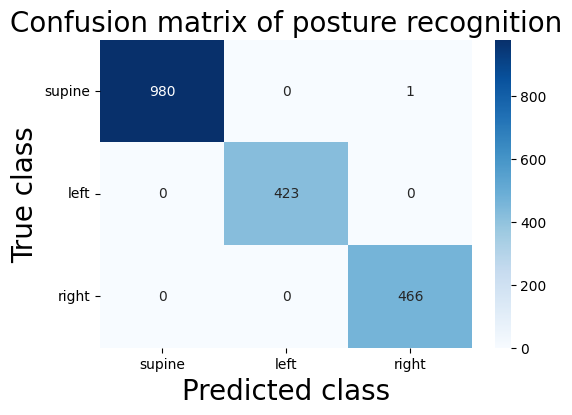

In [26]:
#'supine': 0, 'left': 1, 'right': 2,

positions_i_sorted = ['supine', 'left', 'right']

posture_cm = confusion_matrix(y_true=y_true, y_pred=y_pred_posture)

fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(posture_cm, annot=True, ax = ax, fmt = 'g',cmap='Blues')

# labels, title and ticks
ax.set_xlabel('Predicted class', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=0)
ax.xaxis.set_ticklabels(positions_i_sorted, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True class', fontsize=20)
ax.yaxis.set_ticklabels(positions_i_sorted, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion matrix of posture recognition', fontsize=20)

plt.show()

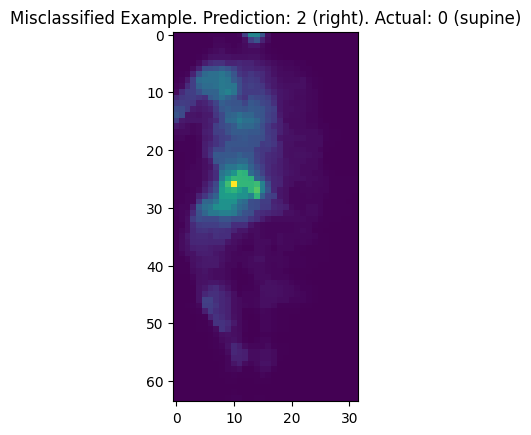

In [27]:
plt.title('Misclassified Example. Prediction: 2 (right). Actual: 0 (supine)')
plt.imshow(X_test[149])
plt.show()

In [28]:
# Produce Encodings

encodings = encoding_model.predict(X)

print('Shape of Encodings:', encodings.shape)

528/585 [==========================>...] - ETA: 0s

585/585 [==============================] - 1s 900us/step
Shape of Encodings: (18698, 256)


In [22]:
"""Kernel K-means"""

# Author: Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

import numpy as np

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_random_state


class KernelKMeans(BaseEstimator, ClusterMixin):
    """
    Kernel K-means
    
    Reference
    ---------
    Kernel k-means, Spectral Clustering and Normalized Cuts.
    Inderjit S. Dhillon, Yuqiang Guan, Brian Kulis.
    KDD 2004.
    """

    def __init__(self, n_clusters=3, max_iter=50, tol=1e-3, random_state=None,
                 kernel="linear", gamma=None, degree=3, coef0=1,
                 kernel_params=None, verbose=0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params
        self.verbose = verbose
        
    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def _get_kernel(self, X, Y=None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma,
                      "degree": self.degree,
                      "coef0": self.coef0}
        return pairwise_kernels(X, Y, metric=self.kernel,
                                filter_params=True, **params)

    def fit(self, X, y=None, sample_weight=None):
        n_samples = X.shape[0]

        K = self._get_kernel(X)

        sw = sample_weight if sample_weight else np.ones(n_samples)
        self.sample_weight_ = sw

        rs = check_random_state(self.random_state)
        self.labels_ = rs.randint(self.n_clusters, size=n_samples)

        dist = np.zeros((n_samples, self.n_clusters))
        self.within_distances_ = np.zeros(self.n_clusters)

        for it in range(self.max_iter):
            dist.fill(0)
            self._compute_dist(K, dist, self.within_distances_,
                               update_within=True)
            labels_old = self.labels_
            self.labels_ = dist.argmin(axis=1)

            # Compute the number of samples whose cluster did not change 
            # since last iteration.
            n_same = np.sum((self.labels_ - labels_old) == 0)
            if 1 - float(n_same) / n_samples < self.tol:
                if self.verbose:
                    print("Converged at iteration", it + 1)
                break

        self.X_fit_ = X

        return self

    def _compute_dist(self, K, dist, within_distances, update_within):
        """Compute a n_samples x n_clusters distance matrix using the 
        kernel trick."""
        sw = self.sample_weight_

        for j in range(self.n_clusters):
            mask = self.labels_ == j

            if np.sum(mask) == 0:
                raise ValueError("Empty cluster found, try smaller n_cluster.")

            denom = sw[mask].sum()
            denomsq = denom * denom

            if update_within:
                KK = K[mask][:, mask]  # K[mask, mask] does not work.
                dist_j = np.sum(np.outer(sw[mask], sw[mask]) * KK / denomsq)
                within_distances[j] = dist_j
                dist[:, j] += dist_j
            else:
                dist[:, j] += within_distances[j]

            dist[:, j] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / denom

    def predict(self, X):
        K = self._get_kernel(X, self.X_fit_)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.n_clusters))
        self._compute_dist(K, dist, self.within_distances_,
                           update_within=False)
        return dist.argmin(axis=1)


In [38]:
# Randomly sample encodings

idx = np.random.randint(encodings.shape[0], size=100)

encodings_sample = encodings[idx,:]

X_img = X[idx,:]
y_img = y[idx]

IndexError: invalid index to scalar variable.

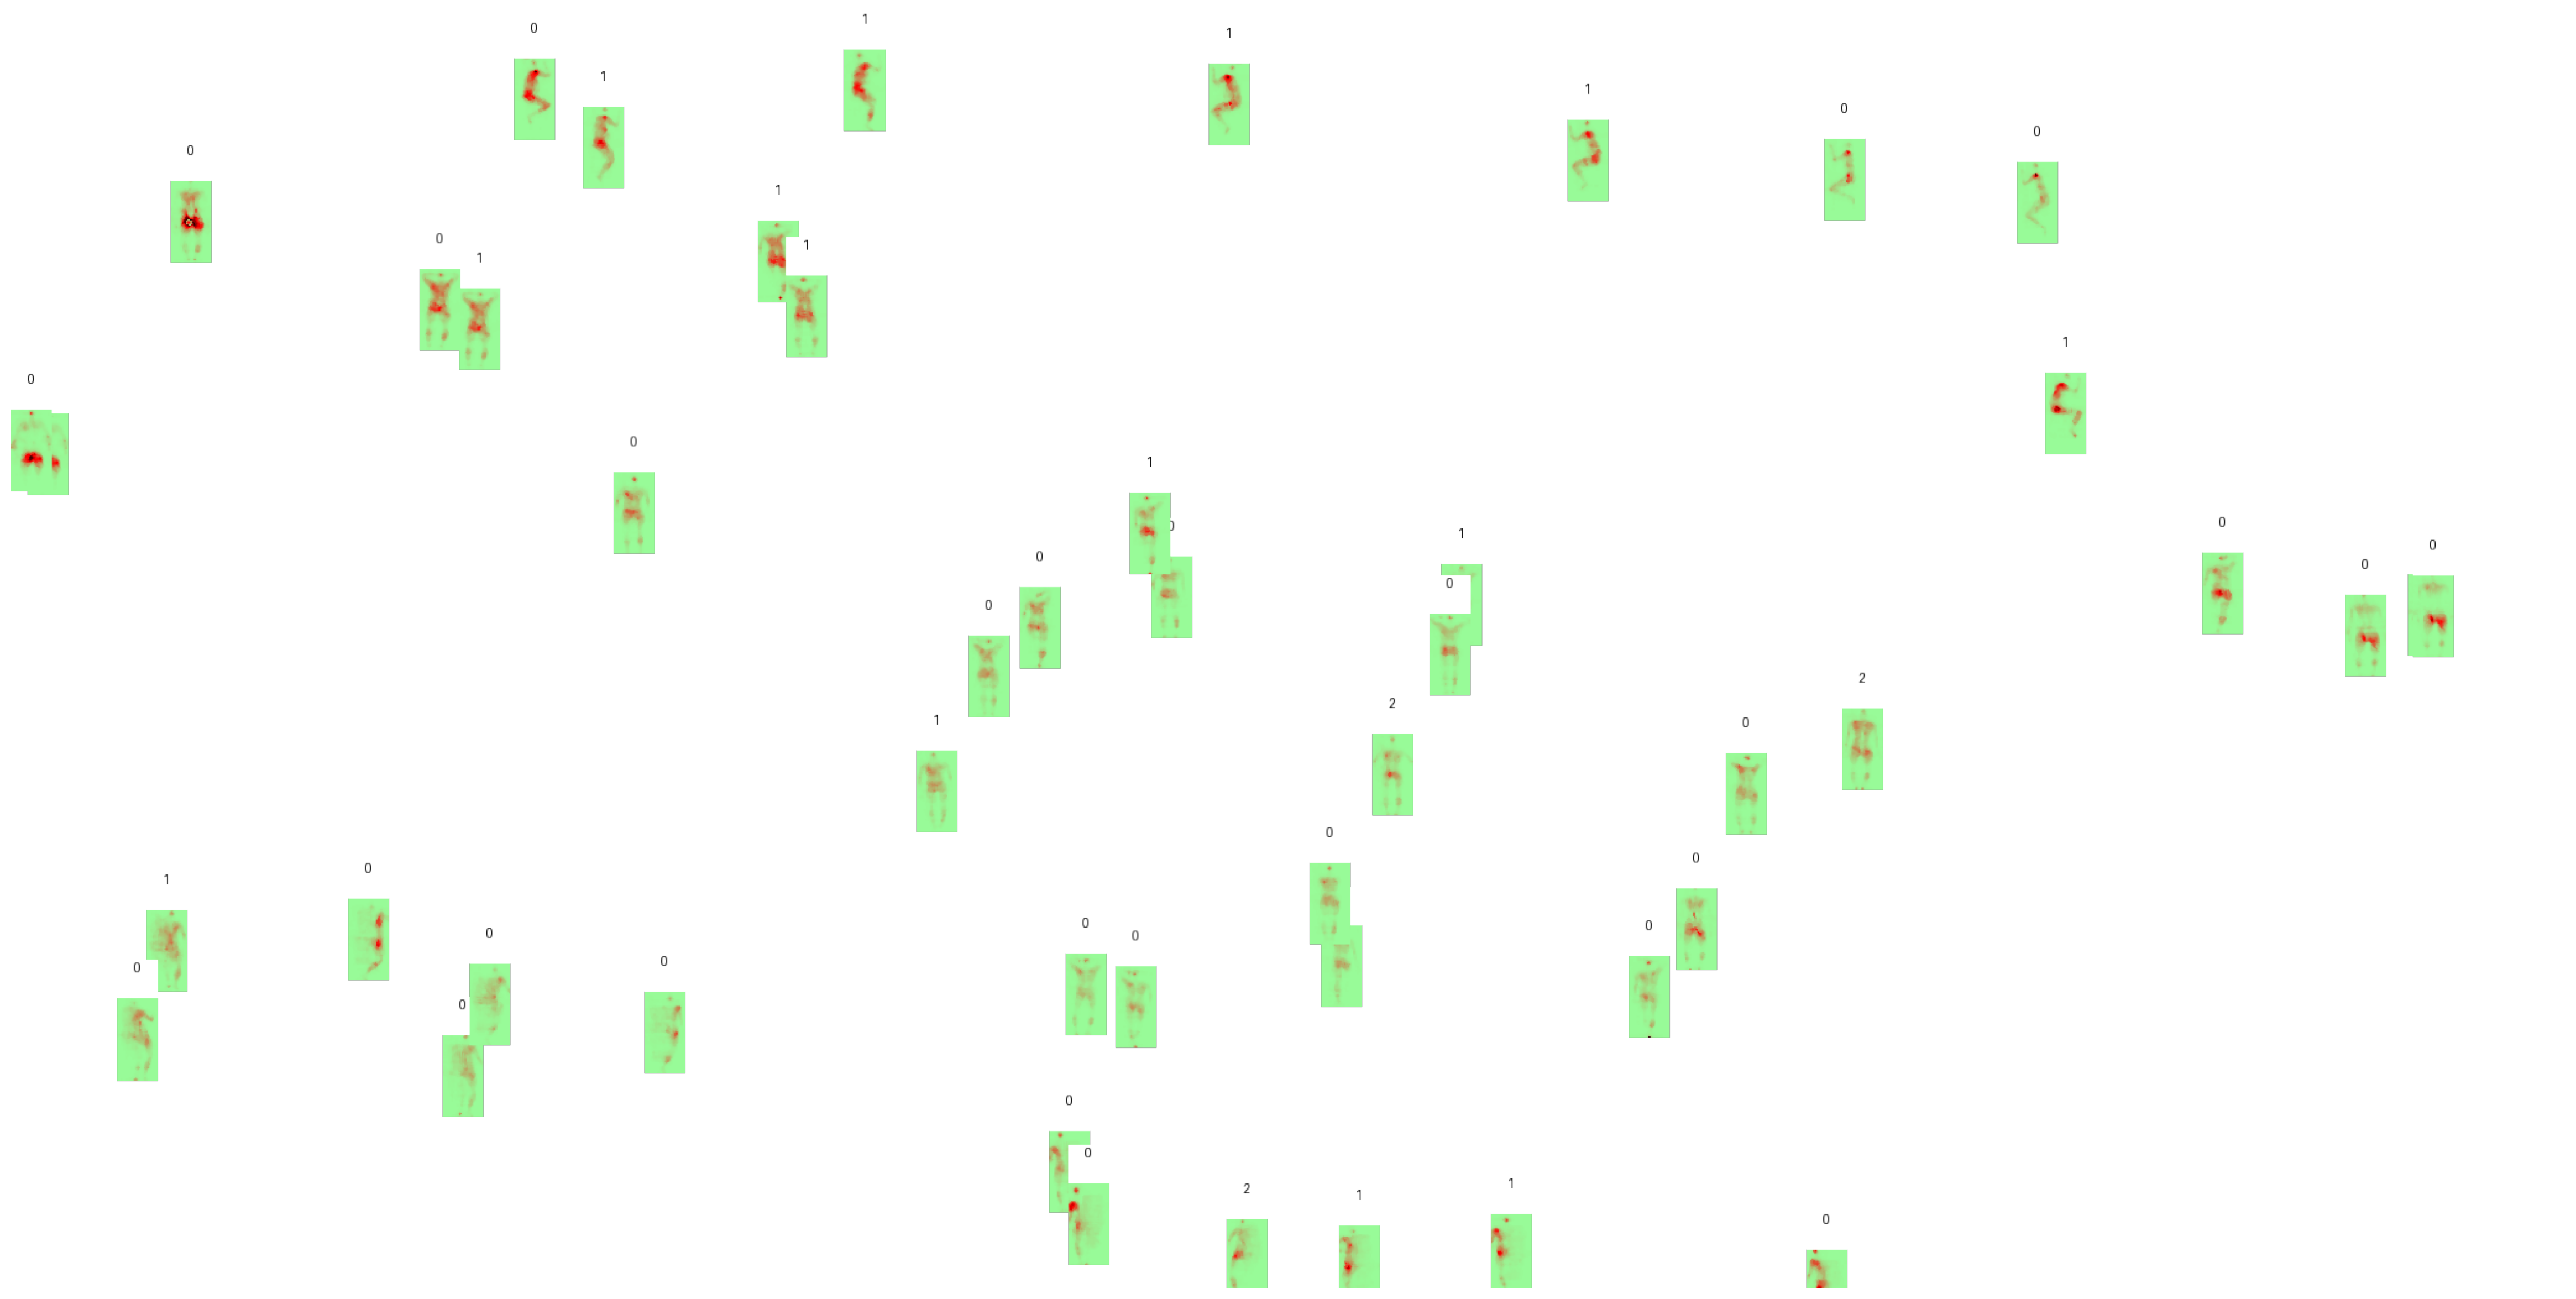

In [33]:
# tSNE

from PIL import Image, ImageOps, ImageDraw, ImageFont
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30, random_state=123).fit_transform(encodings_sample)

# Visualize tsne

tx, ty = tsne[:, 0], tsne[:, 1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
width = 2000
height = 1000

font = ImageFont.load_default()

full_image = Image.new('RGBA', (width, height))

for img, label, x, y in zip(X_img, y_img, tx, ty):
    tile = Image.fromarray(np.squeeze(img).astype('uint8'), mode='L')
    tile = ImageOps.colorize(
        tile, black='palegreen', mid='red', white='black')
    
    # Create a new image with space for the label
    label_height = 30
    new_tile = Image.new('RGBA', (tile.width, tile.height + label_height), (255, 255, 255, 0))
    
    # Draw the text label on the new image
    draw = ImageDraw.Draw(new_tile)
    text_bbox = draw.textbbox((0, 0), str(label), font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_x = (new_tile.width - text_width) // 2
    draw.text((text_x, 0), str(label), fill='black', font=font)
    
    # Paste the original image below the text label
    new_tile.paste(tile, (0, label_height))
    
    # Paste the new tile onto the full image
    tile_x = int((width - 60) * x)
    tile_y = int((height - 60) * y)
    full_image.paste(new_tile, (tile_x, tile_y))

plt.figure(figsize=(30, 15), dpi=200)
plt.imshow(full_image)
plt.axis("off")
plt.show()

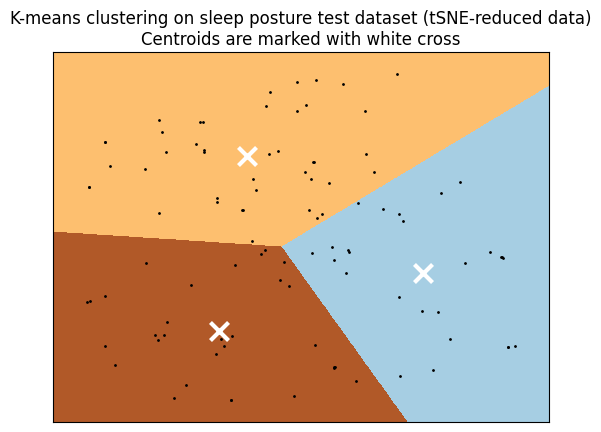

In [36]:
# kmeans clustering

from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=3, n_init=20)
kmeans.fit(tsne.astype('double'))

h = 0.01

# Plot decision boundary

x_min, x_max = tsne[:,0].min()-1, tsne[:,0].max()+1
y_min, y_max = tsne[:,1].min()-1, tsne[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h)    
                    )

# Obtain labels from each point in mesh using last trained model
A = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put results in plot
A = A.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    A,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect='auto',
    origin='lower',
)

plt.plot(tsne[:,0], tsne[:,1], 'k.', markersize=2)

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:,0],
    centroids[:,1],
    marker='x',
    s=169,
    linewidth=3,
    color='w',
    zorder=10,
)

plt.title('K-means clustering on sleep posture test dataset (tSNE-reduced data)\n'
          'Centroids are marked with white cross')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()